Plots visualizations of how different subject/encounter numbers compare to each other for the main conditions of each task/contrast for several Yeo networks.

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# constants
RSM_file = 'complete_rsm_results.pkl'

# yeo labels
network_names = {
    1: "Visual",
    2: "Somatomotor",
    3: "Dorsal Attention",
    4: "Ventral Attention",
    5: "Limbic",
    6: "Frontoparietal Control",
    7: "Default Mode"
}

# main conditions and contrasts that we're interested in looking at
requested_task_contrasts = defaultdict(lambda: defaultdict(list))
requested_task_contrasts['nBack'] = ["twoBack-oneBack"]
requested_task_contrasts['flanker'] = ["incongruent-congruent"]
requested_task_contrasts['directedForgetting'] = ["neg-con"]
requested_task_contrasts['goNogo'] = ["nogo_success-go"]
requested_task_contrasts['shapeMatching'] = ["main_vars"]
requested_task_contrasts['stopSignal'] = ["stop_failure-go"]
requested_task_contrasts['stopSignal'] = ["stop_success-go"]
requested_task_contrasts['cuedTS'] = ["task_switch_cost"]
requested_task_contrasts['spatialTS'] = ["task_switch_cost"]

# all tasks and contrasts
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline", "incongruent-congruent","response_time"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
SUBJECTS = ['sub-s03', 'sub-s10', 'sub-s19', 'sub-s29', 'sub-s43']

In [3]:
# helper function
def load_rsm(filename):
    """
    Simple load function
    
    Parameters:
        filename: filename to load
    
    Returns:
        rsm_results: Loaded RSM dictionary
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    with open(filename, 'rb') as f:
        rsm_results = pickle.load(f)
    
    print(f"Loaded from {filename}")
    return rsm_results


In [4]:
# load all of the calculated RSMs (this includes each subj/encounter/task/contrast for the whole brain and every yeo network

if os.path.exists("complete_rsm_results.pkl"):
    print("File exists!")
    all_rsms = load_rsm("complete_rsm_results")
else:
    print("ERROR does not exist; go back to 3_create_RSMs_first_level.ipynb")

# load the no_rt ones too:
if os.path.exists("complete_rsm_results_no_rt.pkl"):
    print("File exists!")
    all_rsms_no_rt = load_rsm("complete_rsm_results_no_rt")
else:
    print("ERROR the no_rt file does not exist; go back to 3_create_RSMs_first_level.ipynb")

generate_no_rt_results = False # looking at the no_rt results
if generate_no_rt_results:
    all_rsms = all_rsms_no_rt

File exists!
Loaded from complete_rsm_results.pkl
File exists!
Loaded from complete_rsm_results_no_rt.pkl


## Basic visualization

In [5]:
def plot_rsm_clean(all_rsms, task, contrast, region, figsize=(15, 15), 
                         show_subject_only=False, show_encounter_only=False):
    """
    Plot RSM with simple labels
    
    Parameters:
        show_subject_only: Only show subject IDs
        show_encounter_only: Only show encounter numbers
    """
    
    try:
        rsm_data = all_rsms[task][contrast][region]
        rsm_matrix = rsm_data['rsm']
        title = rsm_data["full_title"]
        descriptors = rsm_data.get('descriptors', None)
    except KeyError:
        print(f"Error: Could not find {task}/{contrast}/{region}")
        return
    
    # Create simplified labels
    if descriptors:
        if show_subject_only:
            # Extract just subject IDs
            labels = []
            for desc in descriptors:
                # Assuming format like "sub01:task:contrast:encounter-01"
                parts = desc.split(':')
                subject = parts[0] if parts else f"Map{len(labels)+1}"
                labels.append(subject)
        
        elif show_encounter_only:
            # Extract just encounter numbers
            labels = []
            for desc in descriptors:
                if 'encounter' in desc:
                    encounter_part = desc.split('encounter-')[-1]
                    labels.append(f"E{encounter_part}")
                else:
                    labels.append(f"E{len(labels)+1}")
        else:
            # Use full descriptors
            labels = descriptors
    else:
        labels = [f"Map {i+1}" for i in range(rsm_matrix.shape[0])]
        
    mask = np.eye(rsm_matrix.shape[0], dtype=bool)
    rsm_masked = np.ma.masked_array(rsm_matrix, mask=mask)
            
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(rsm_masked, cmap='RdBu_r', vmin=-1, vmax=1, aspect='equal')

    # add corr labels
    for i in range(rsm_masked.shape[0]):
        for j in range(rsm_masked.shape[1]):
            # if j > i:
            if i!=j:
                value = rsm_masked[i, j]
                
                text_color = 'white' if abs(value) > 0.5 else 'black'
                
                # Format the value
                value_str = f'{value:.{2}f}'
                
                ax.text(j, i, value_str, ha='center', va='center', 
                       color=text_color, fontsize=9)
        
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.6)
    cbar.set_label('Correlation')
    
    # Set labels
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(labels, fontsize=12)
    
    ax.set_title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

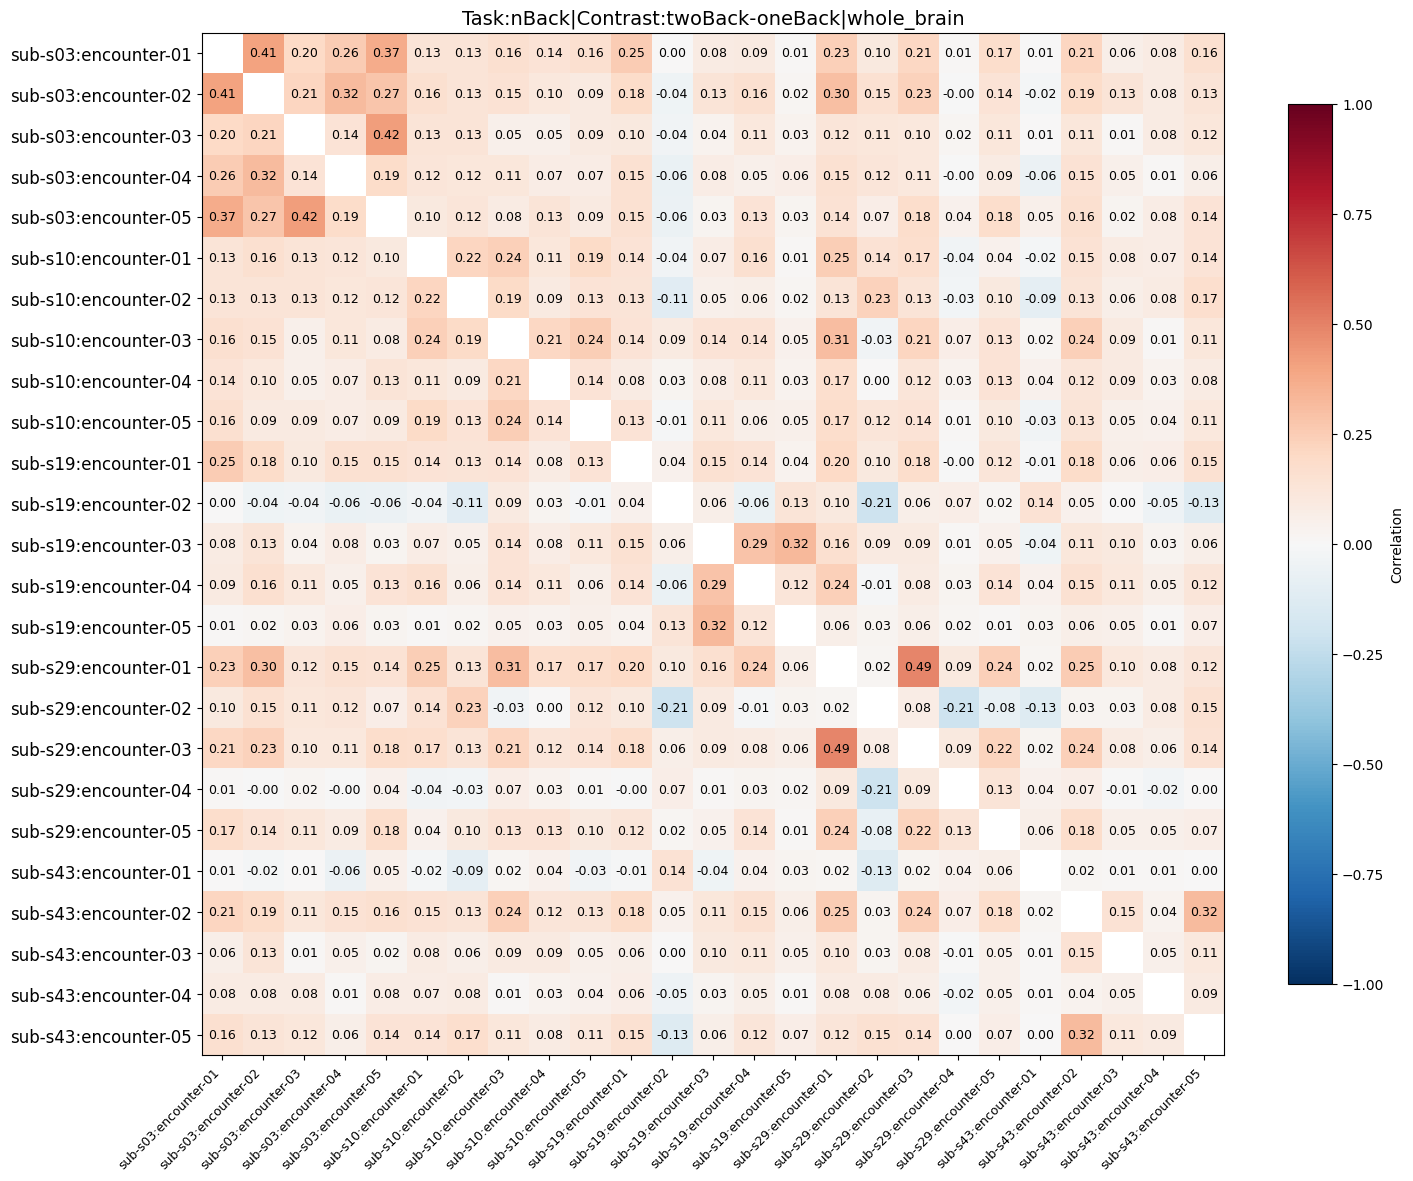

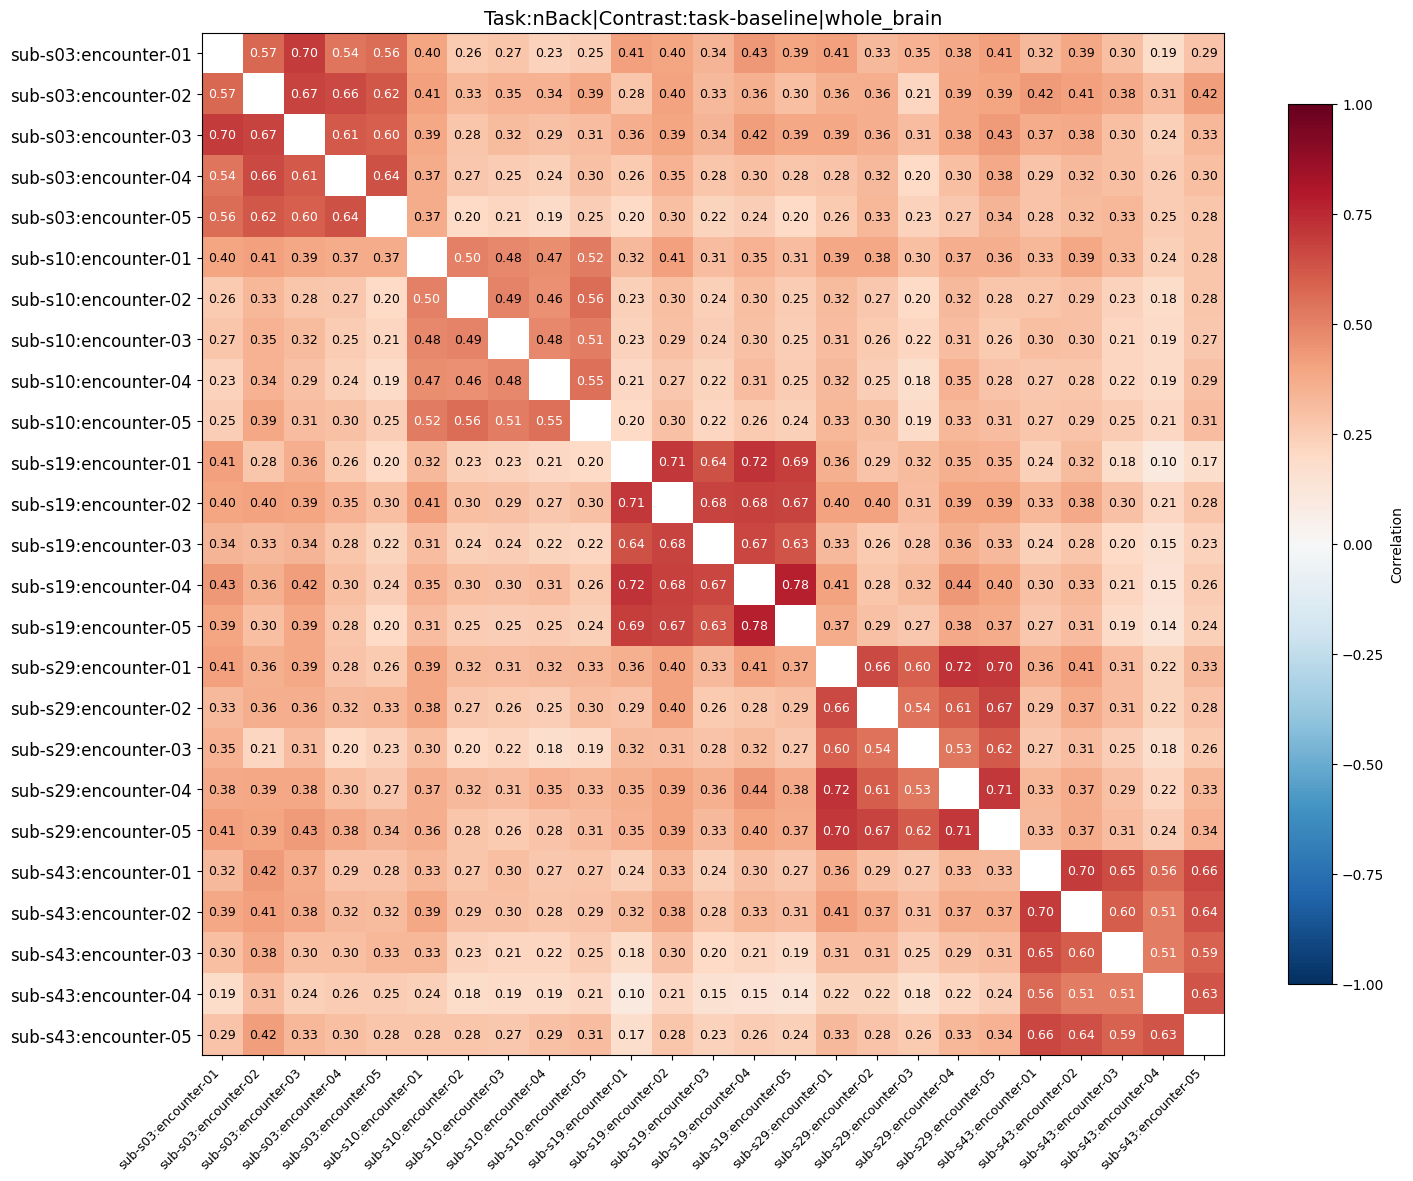

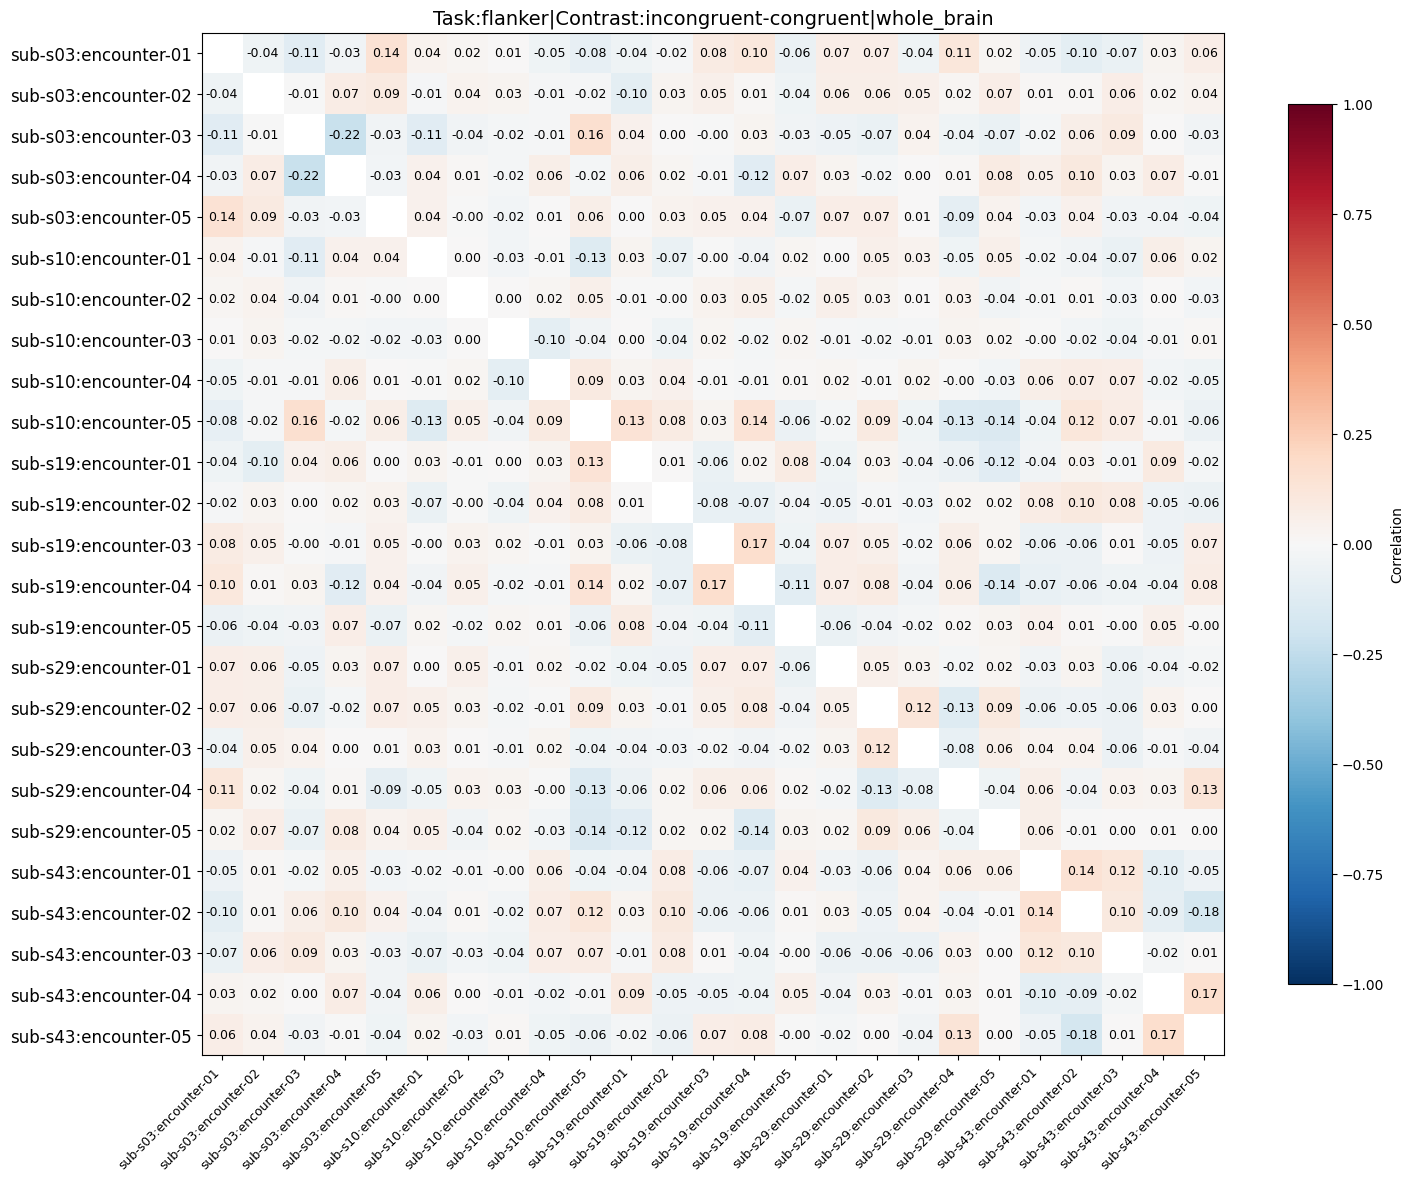

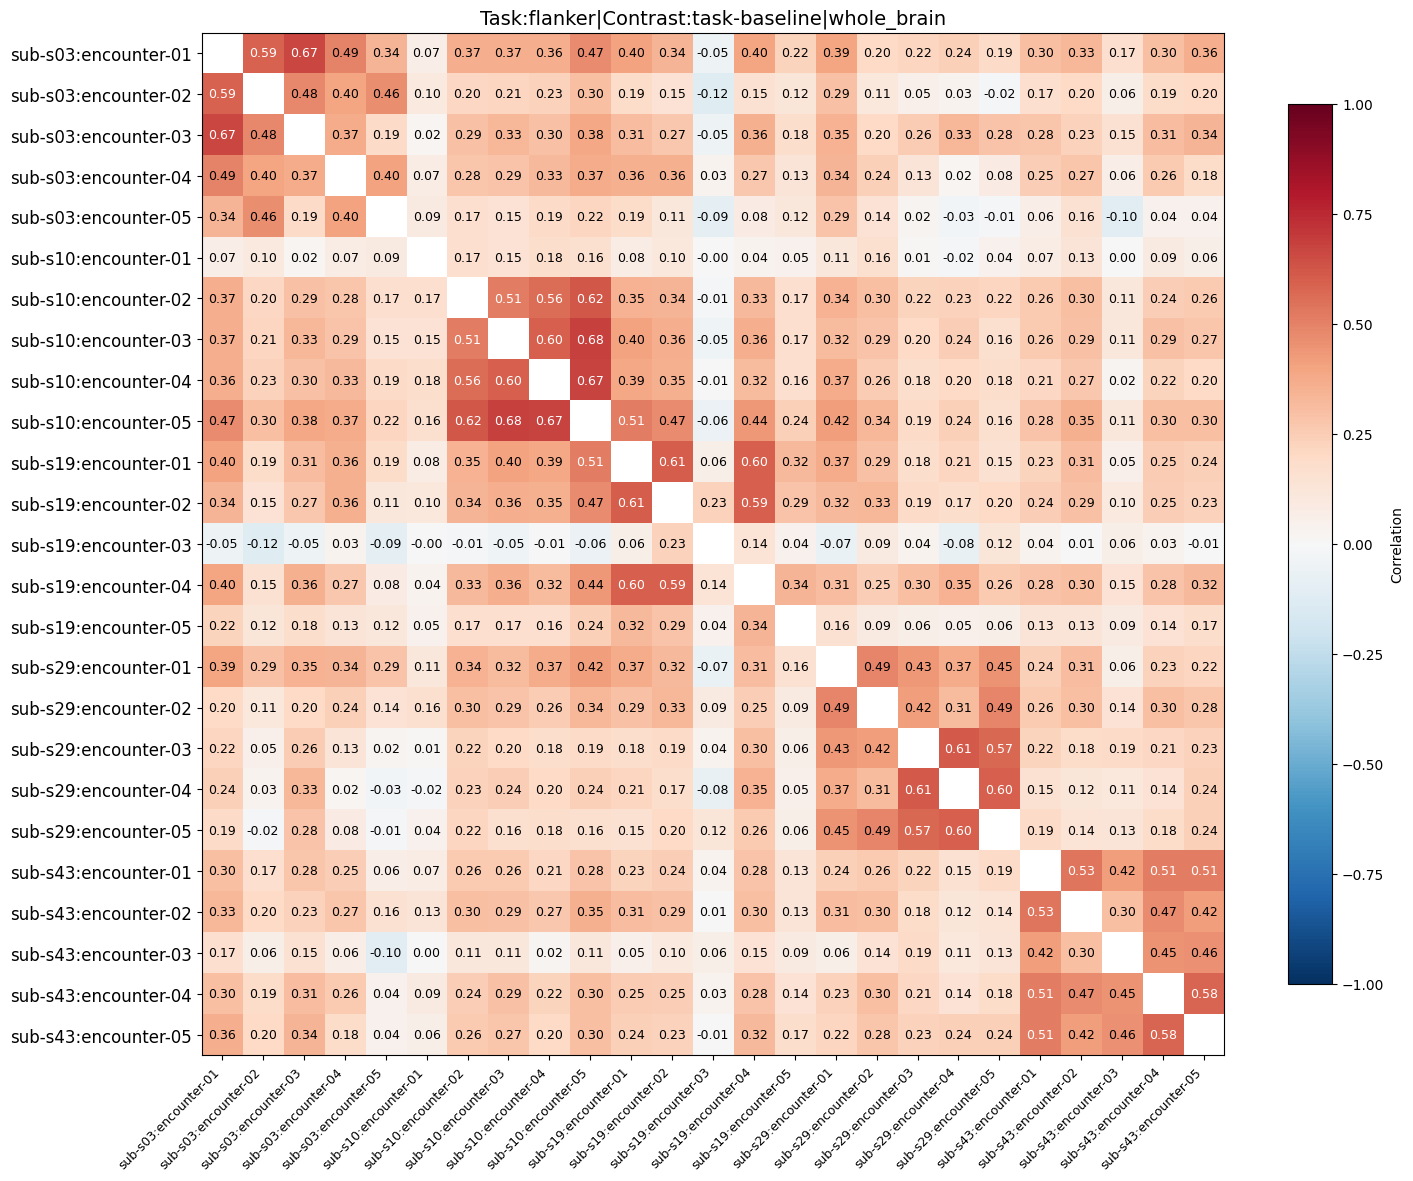

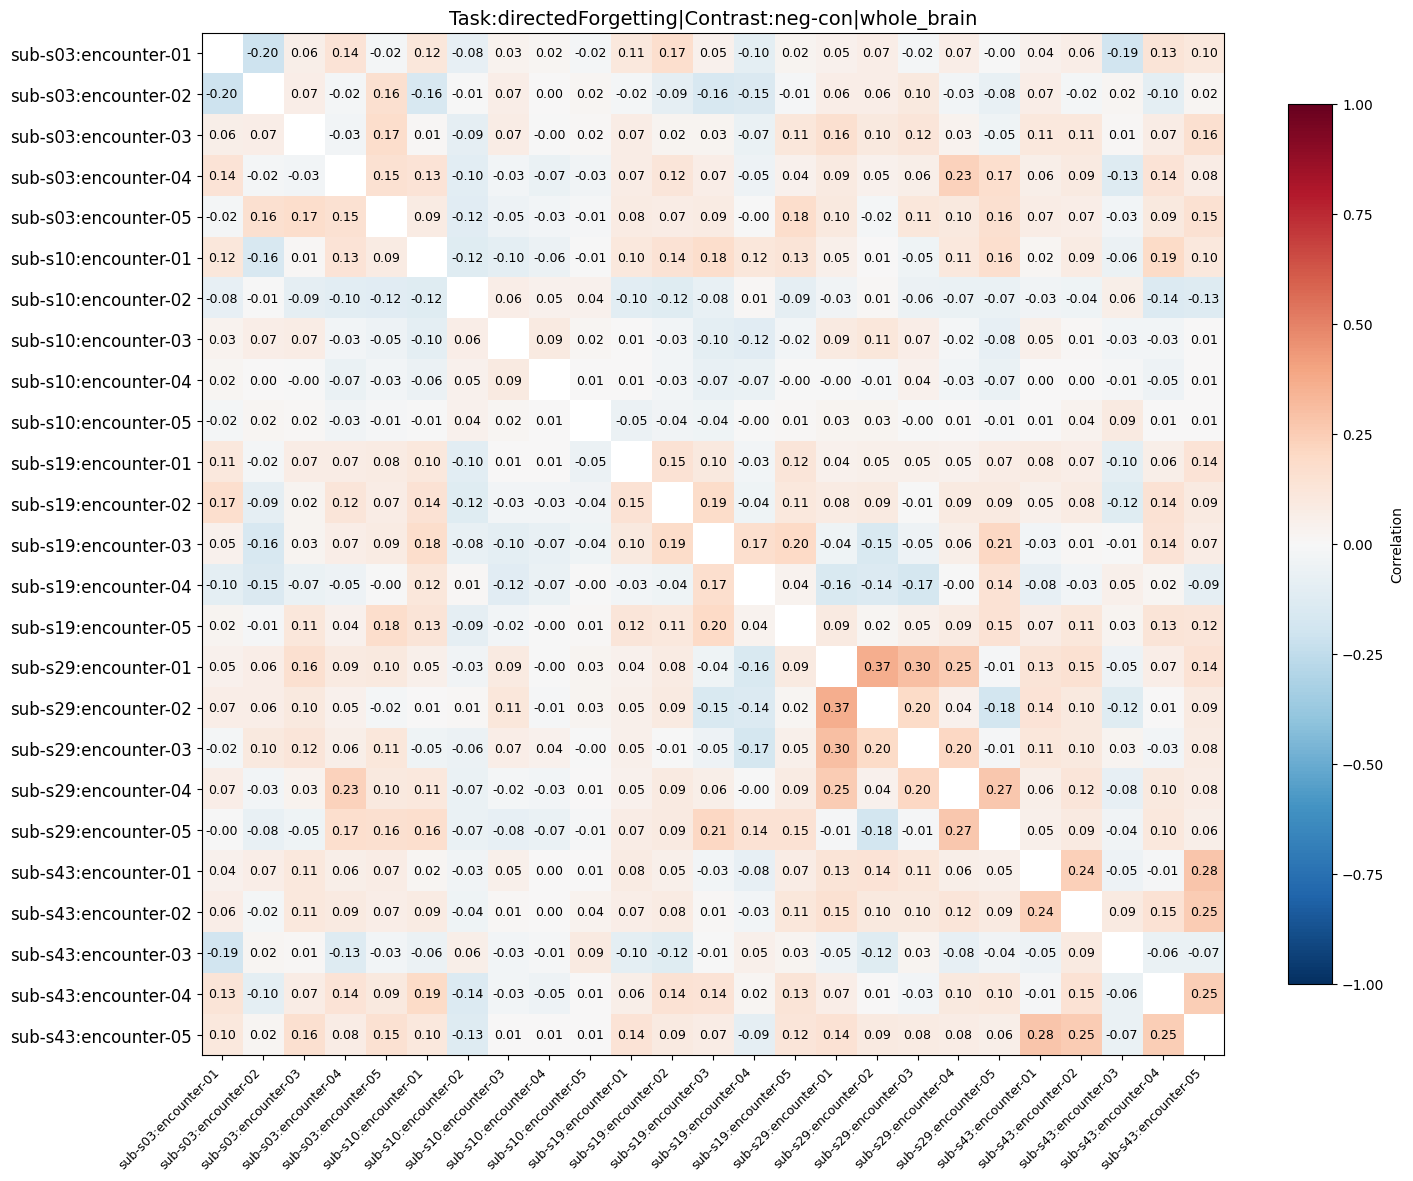

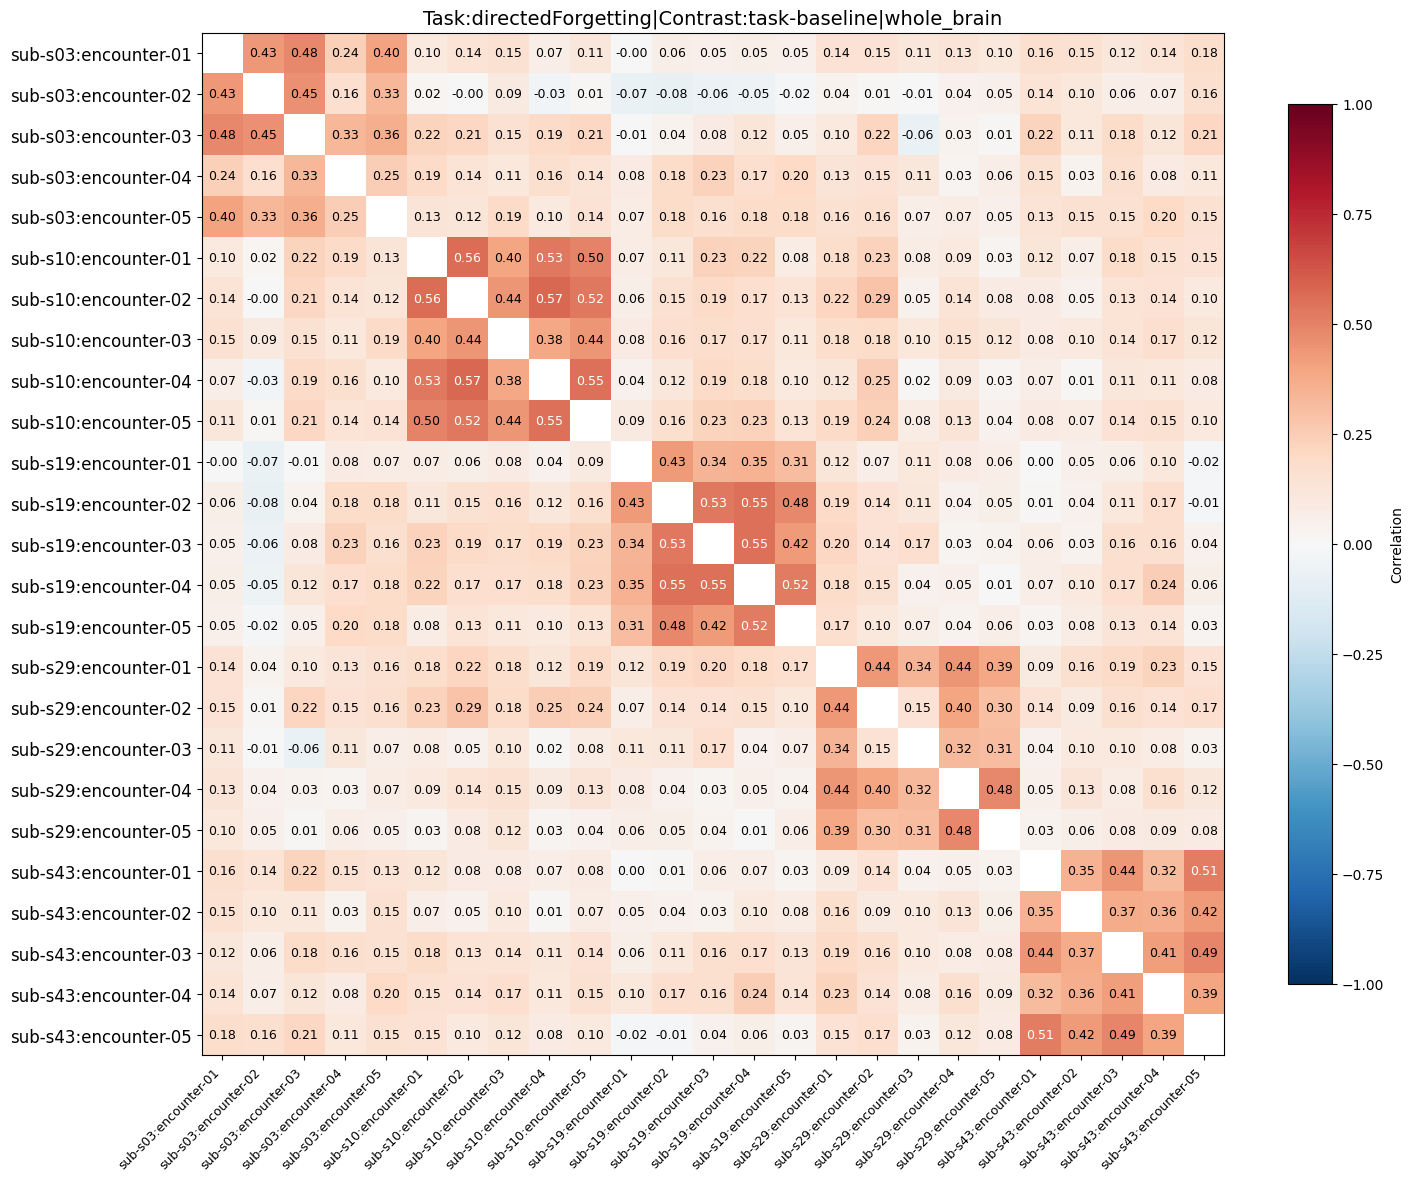

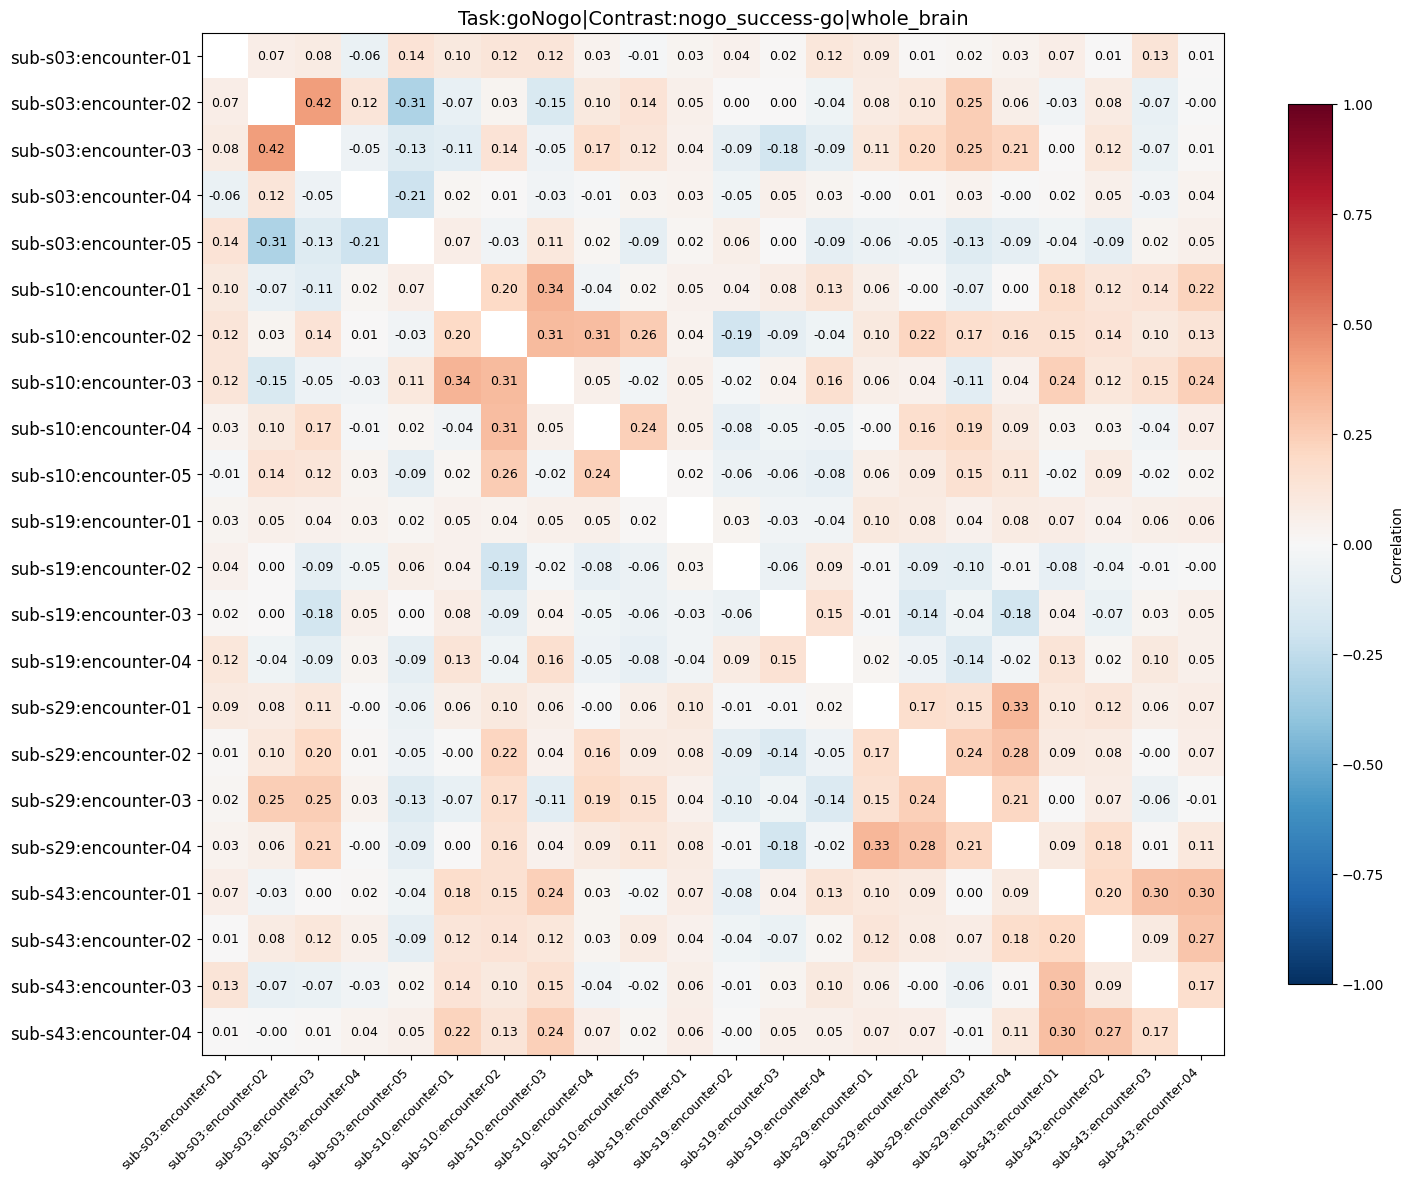

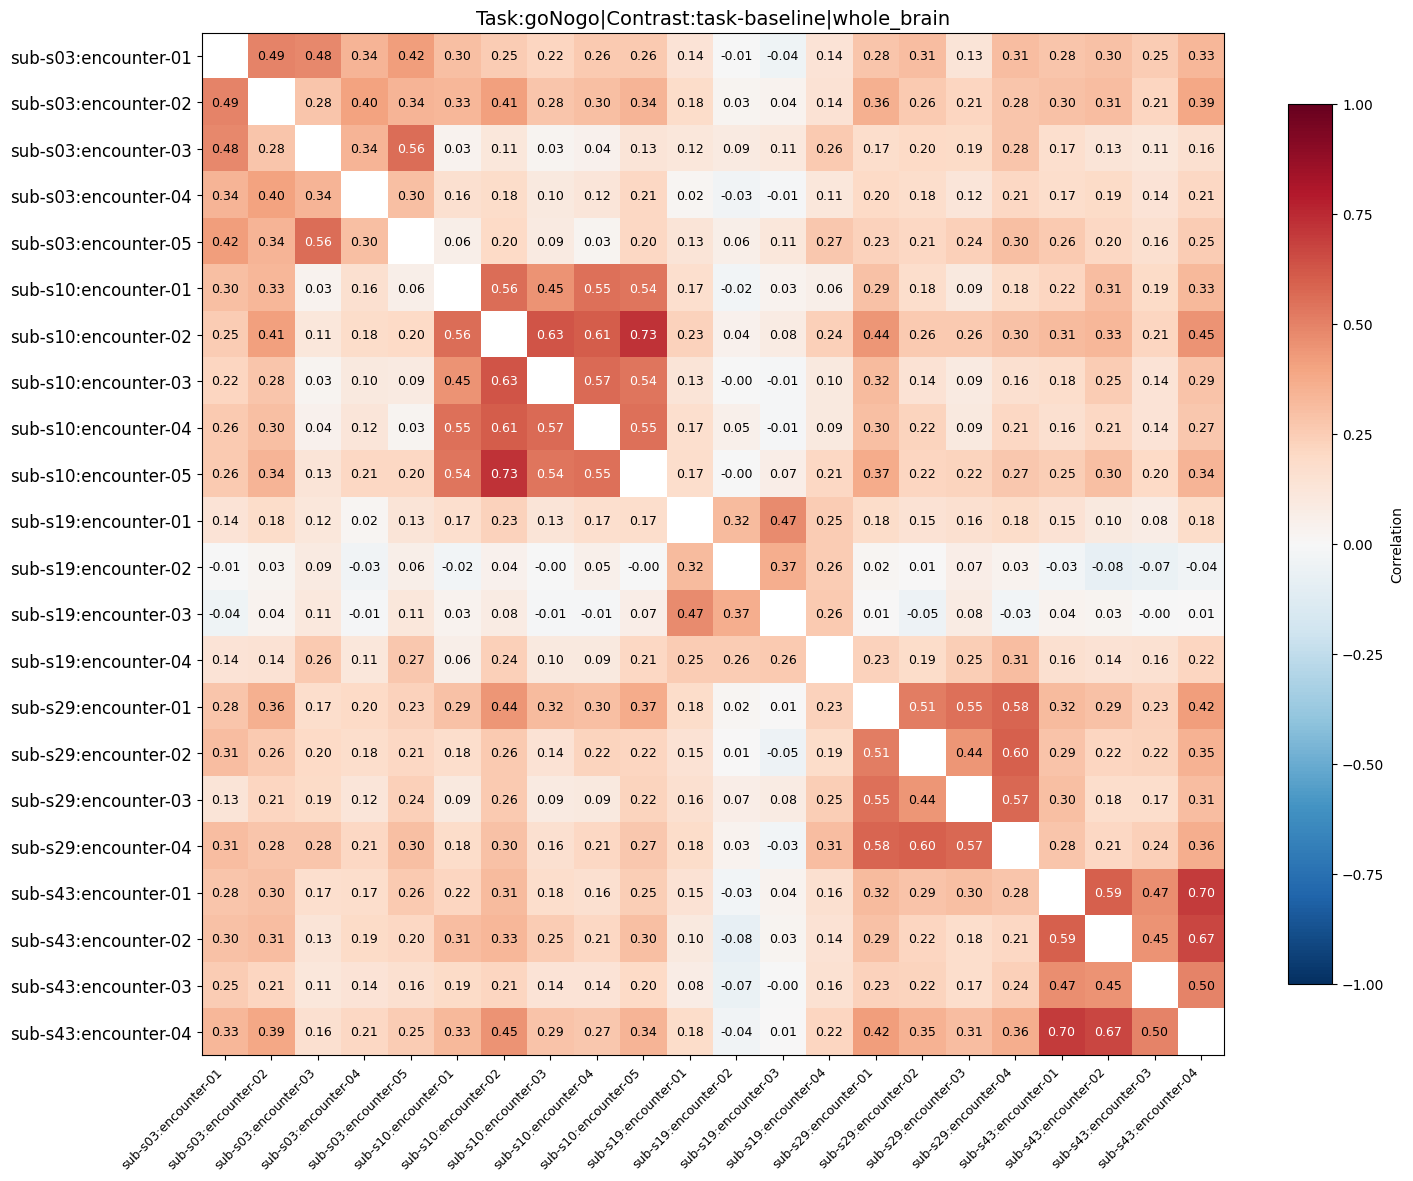

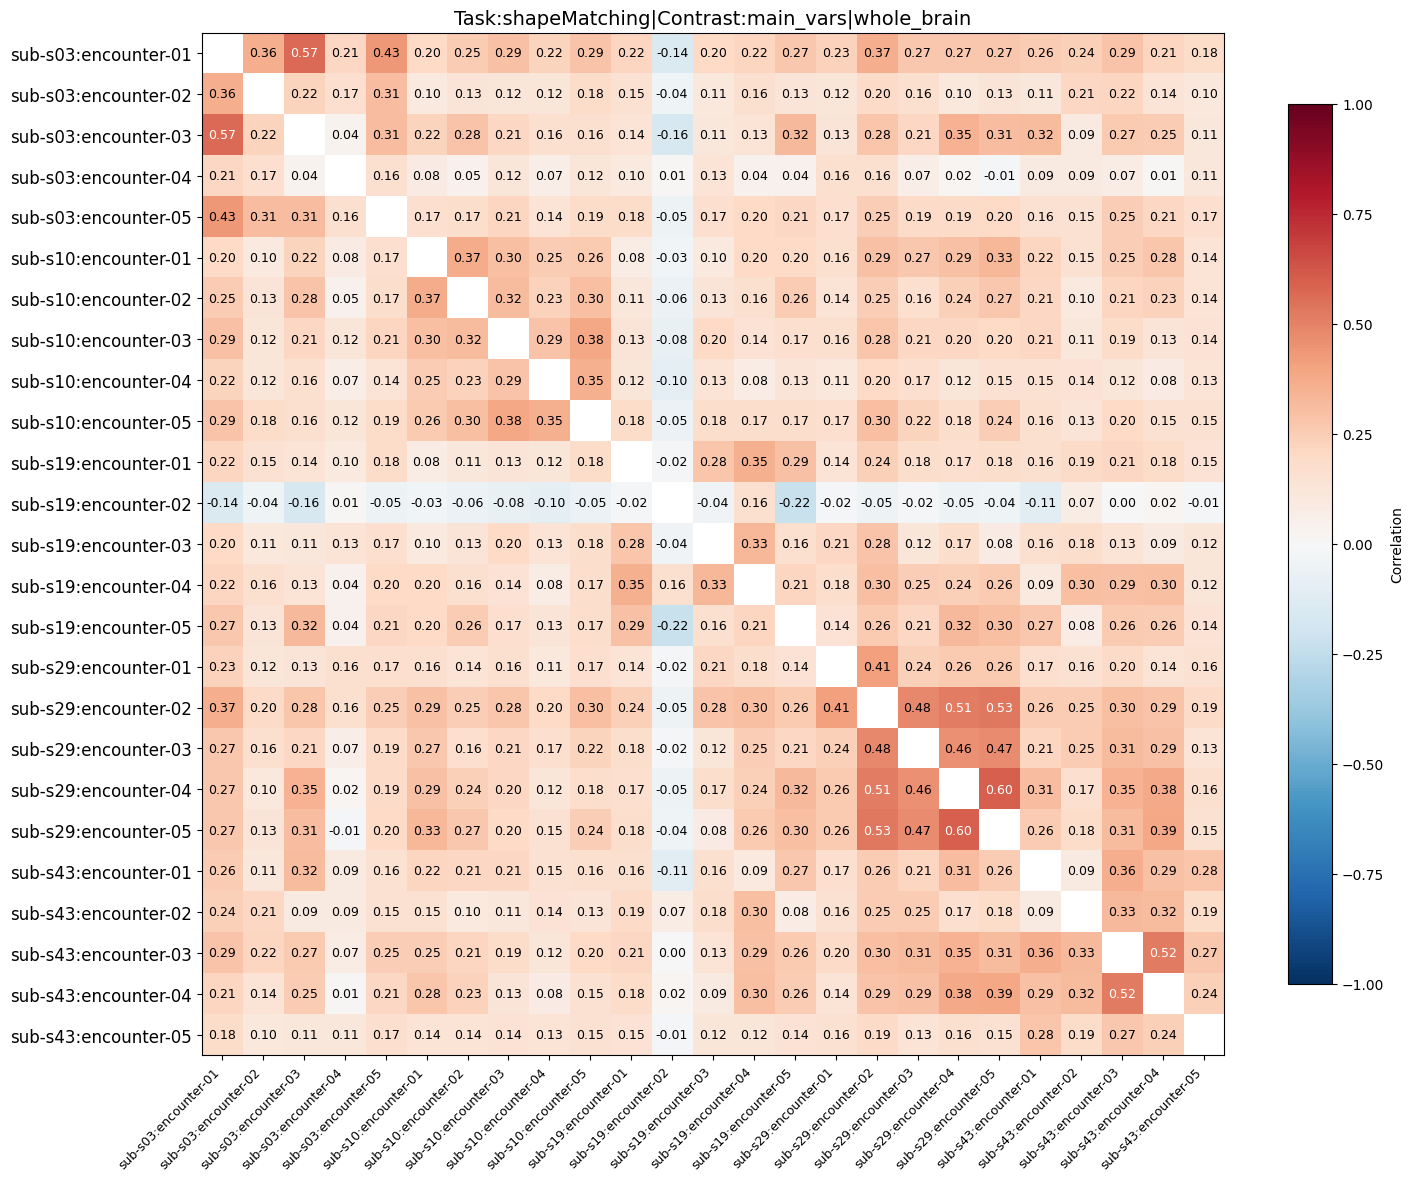

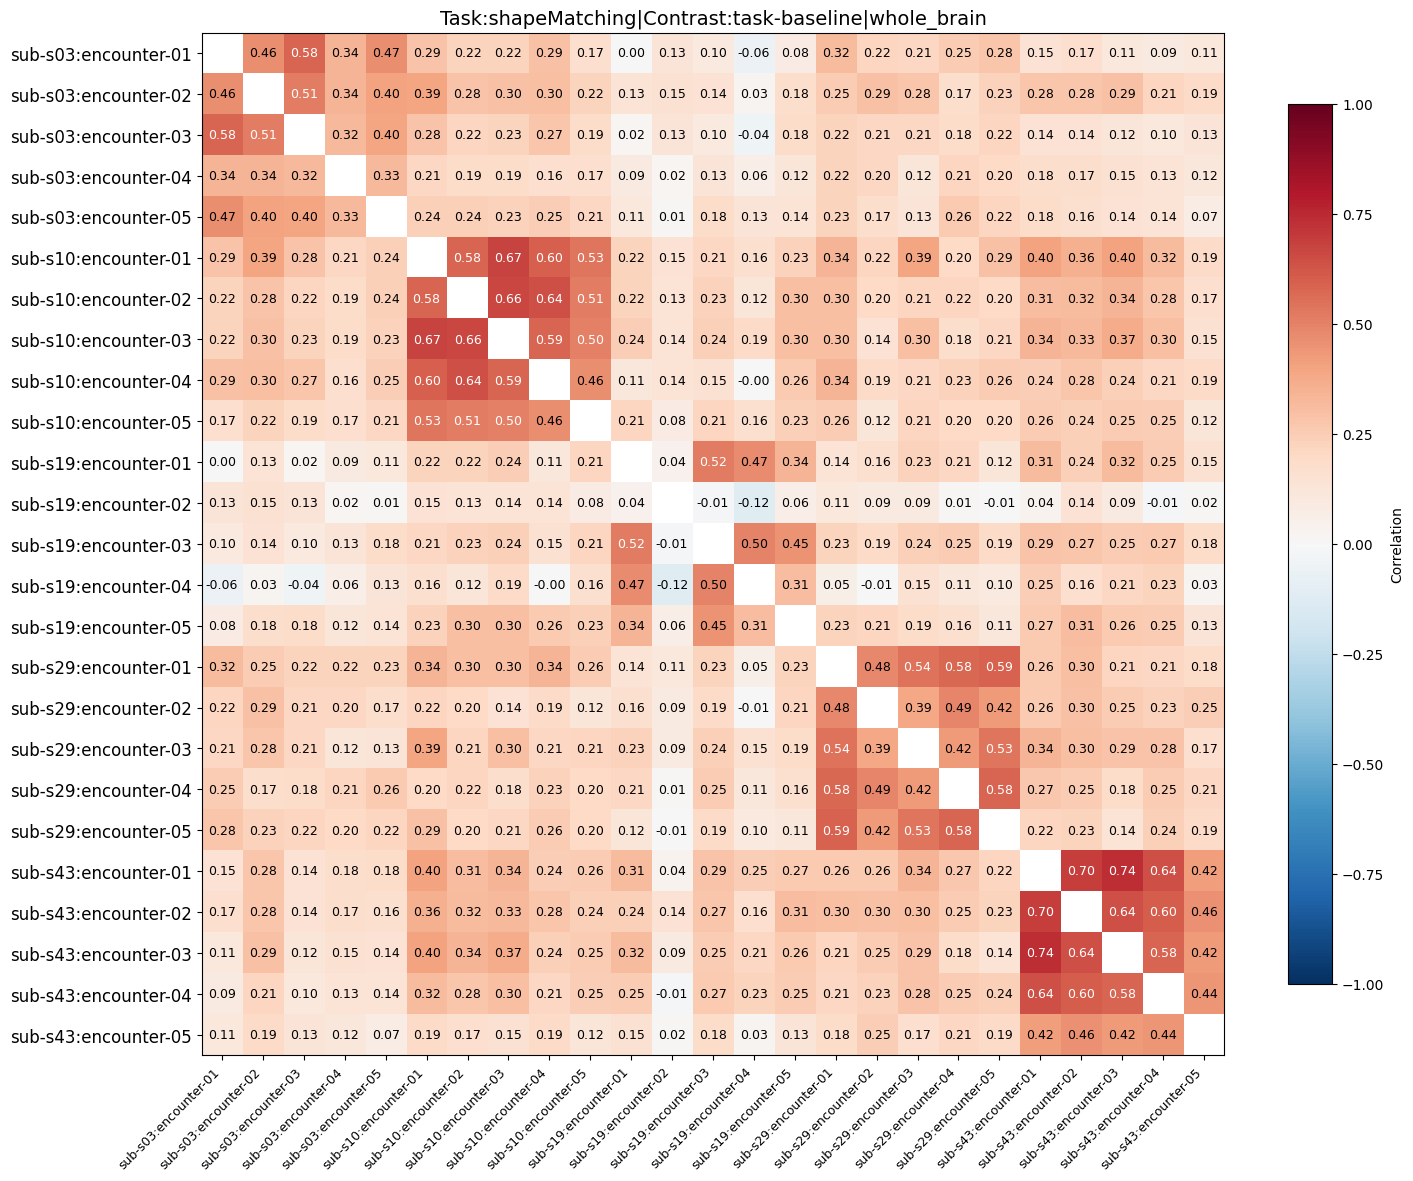

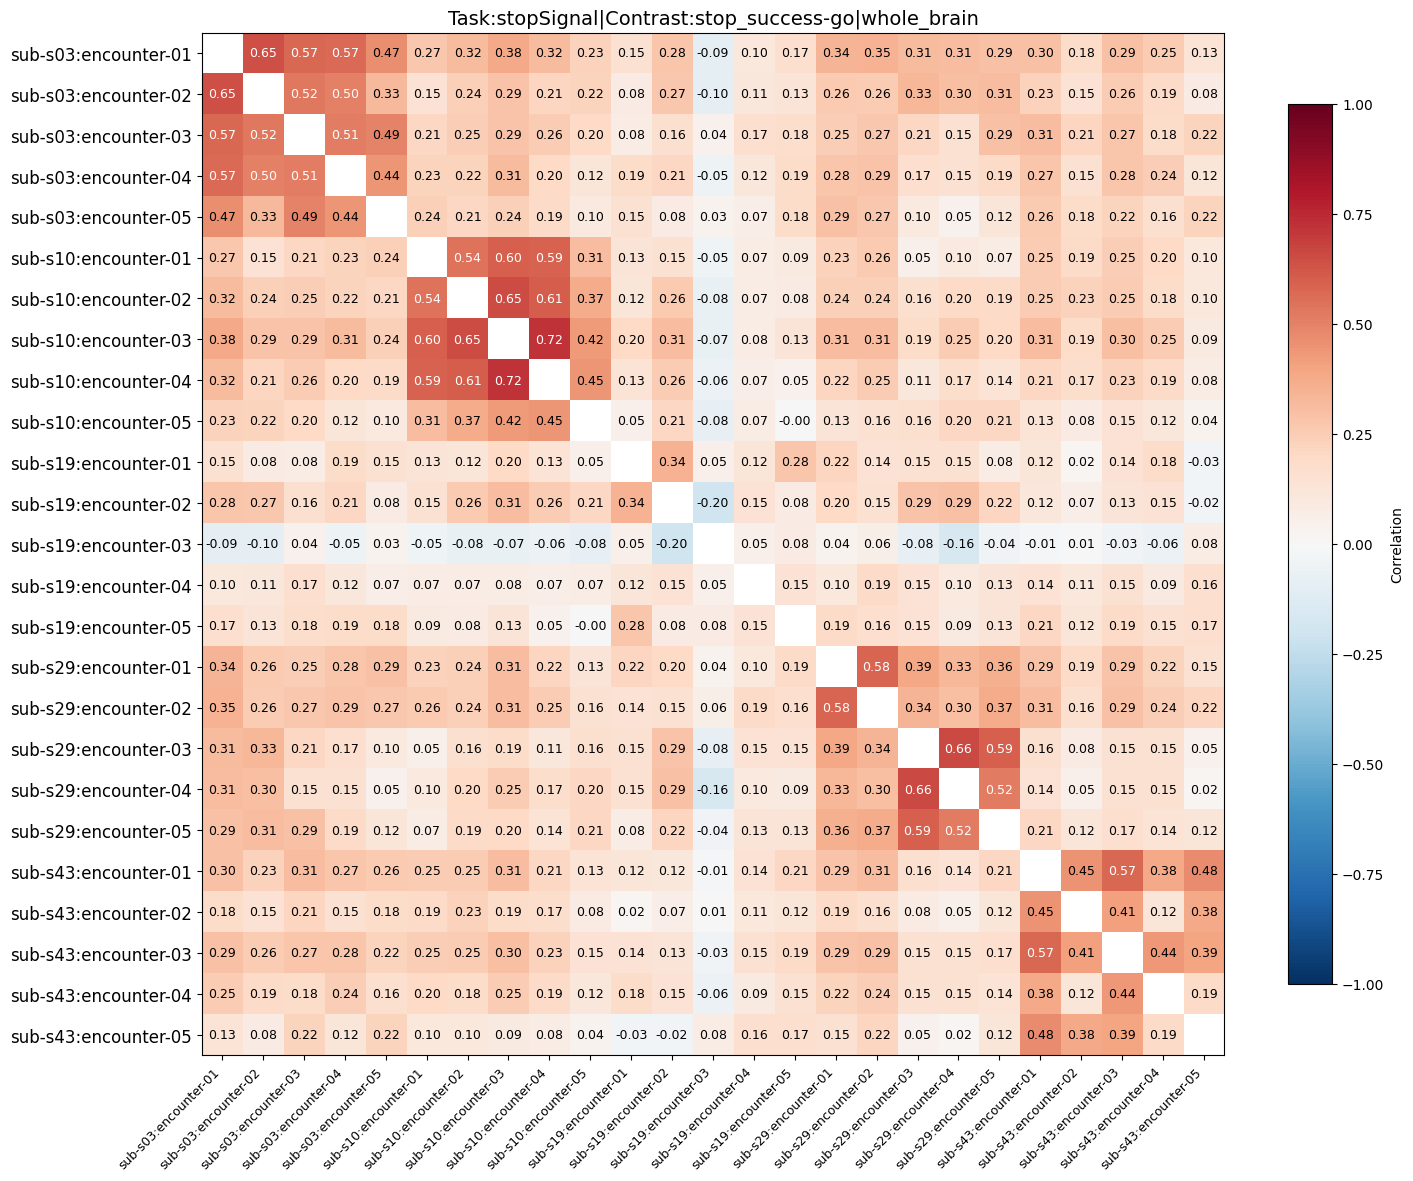

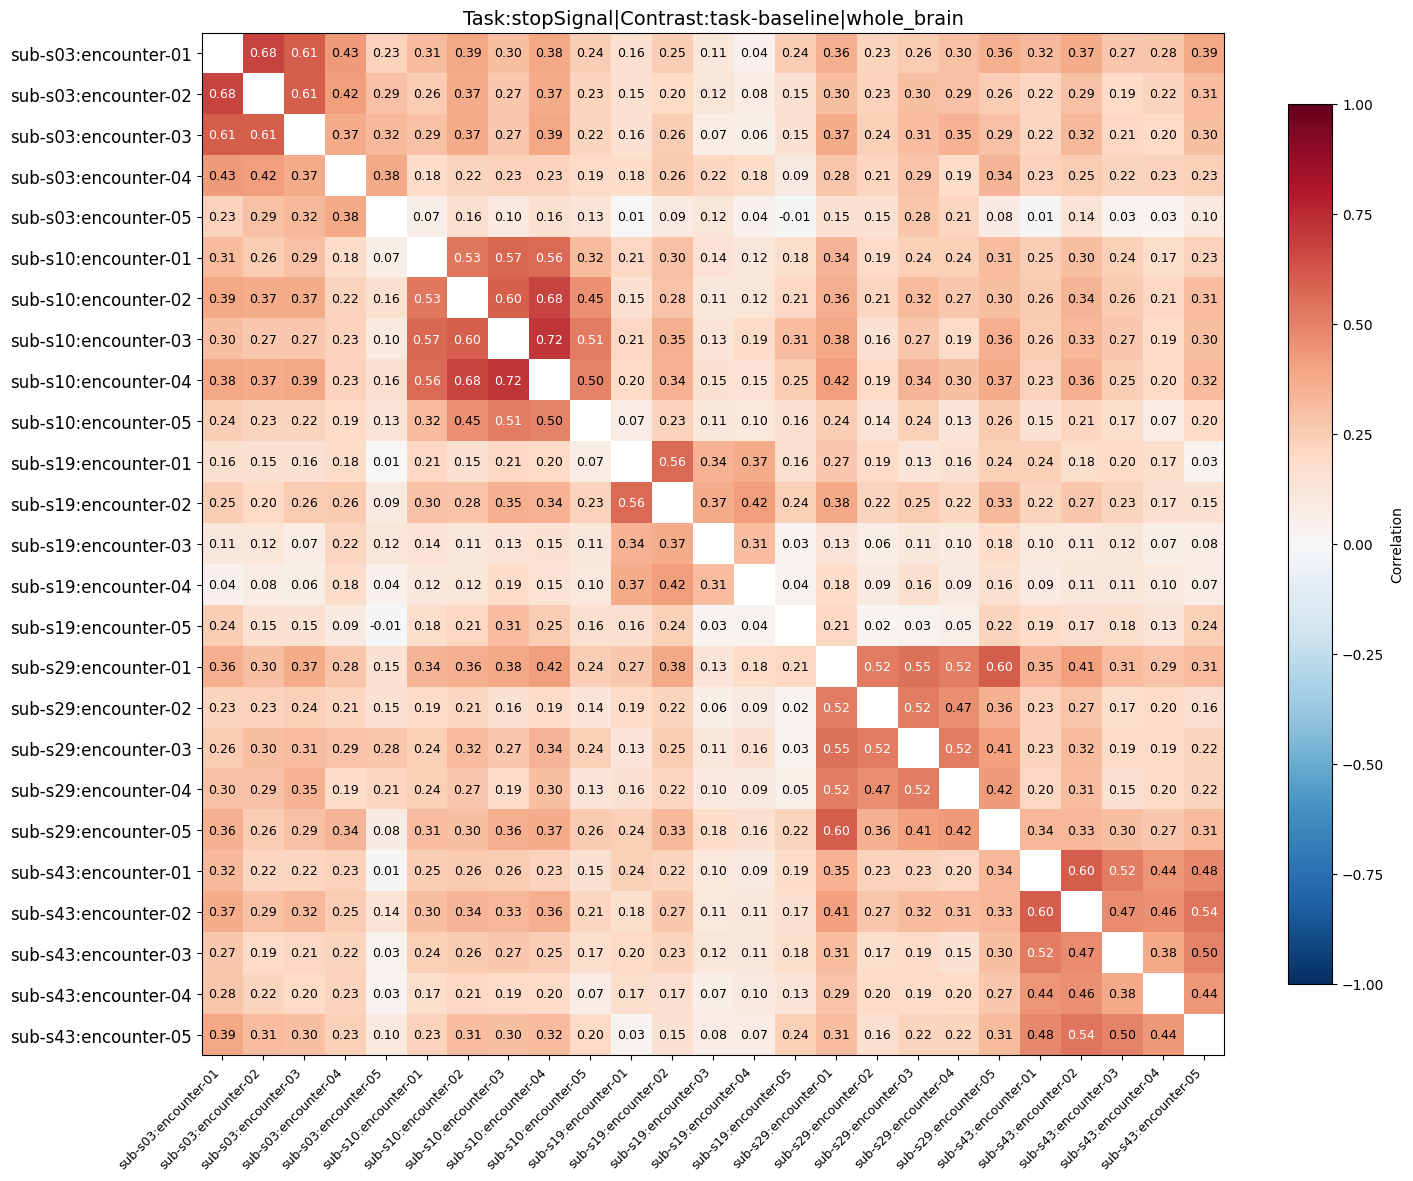

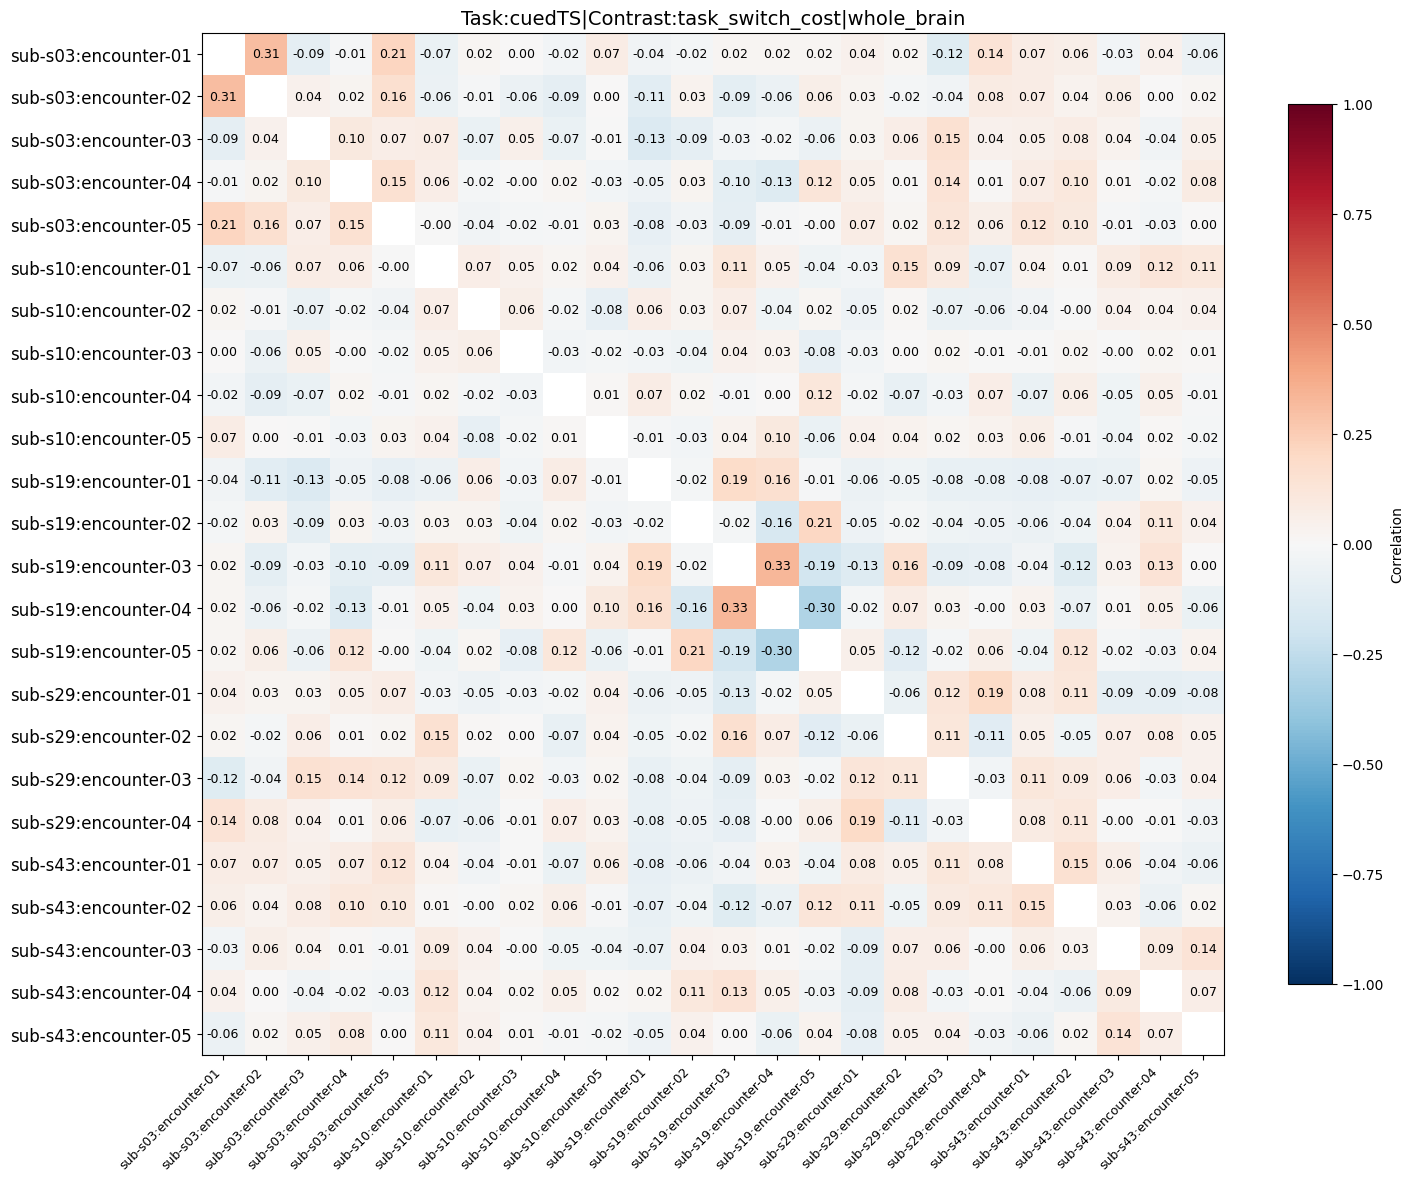

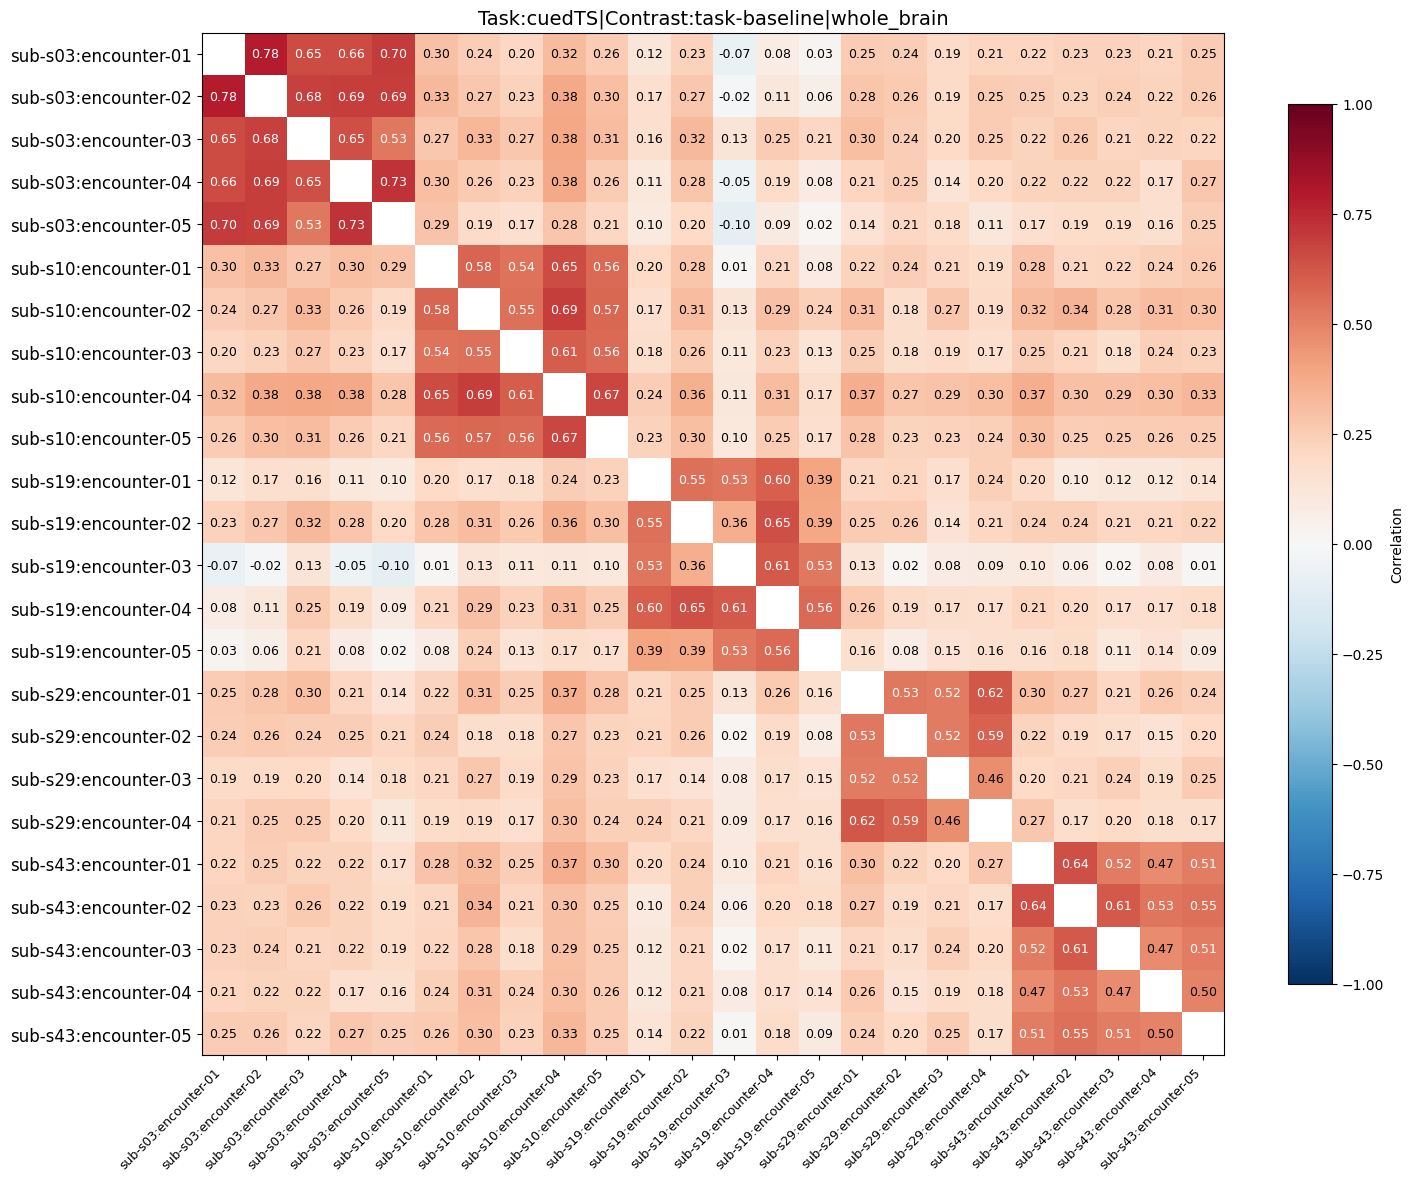

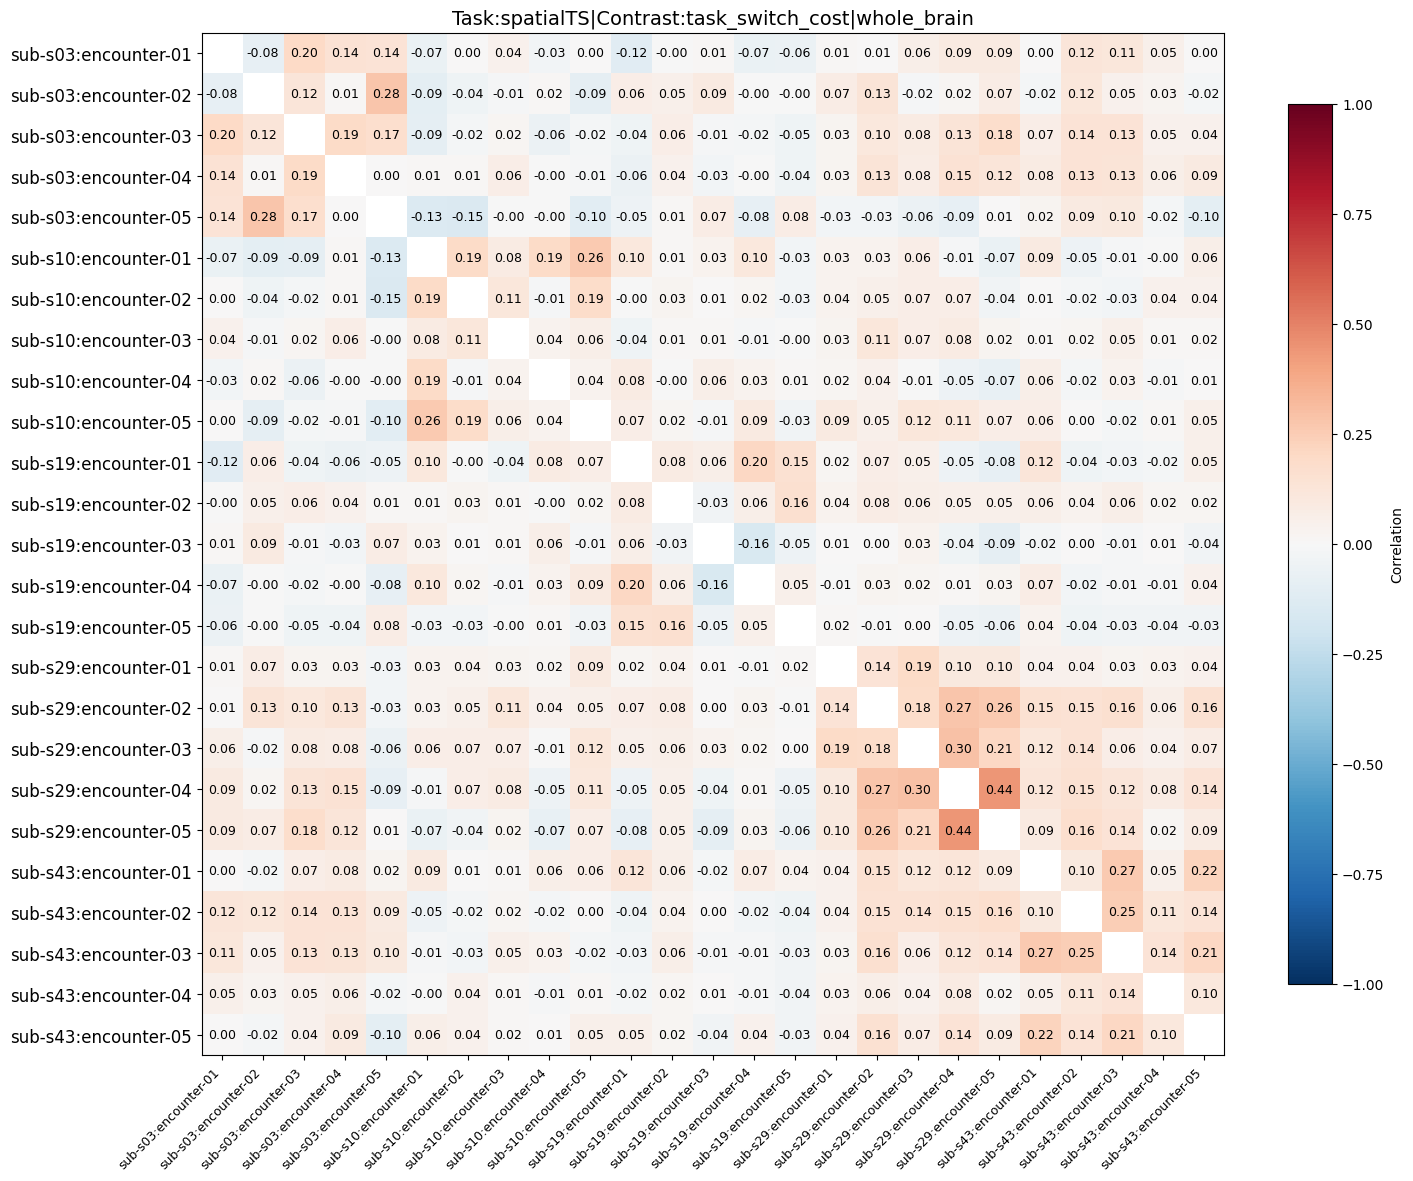

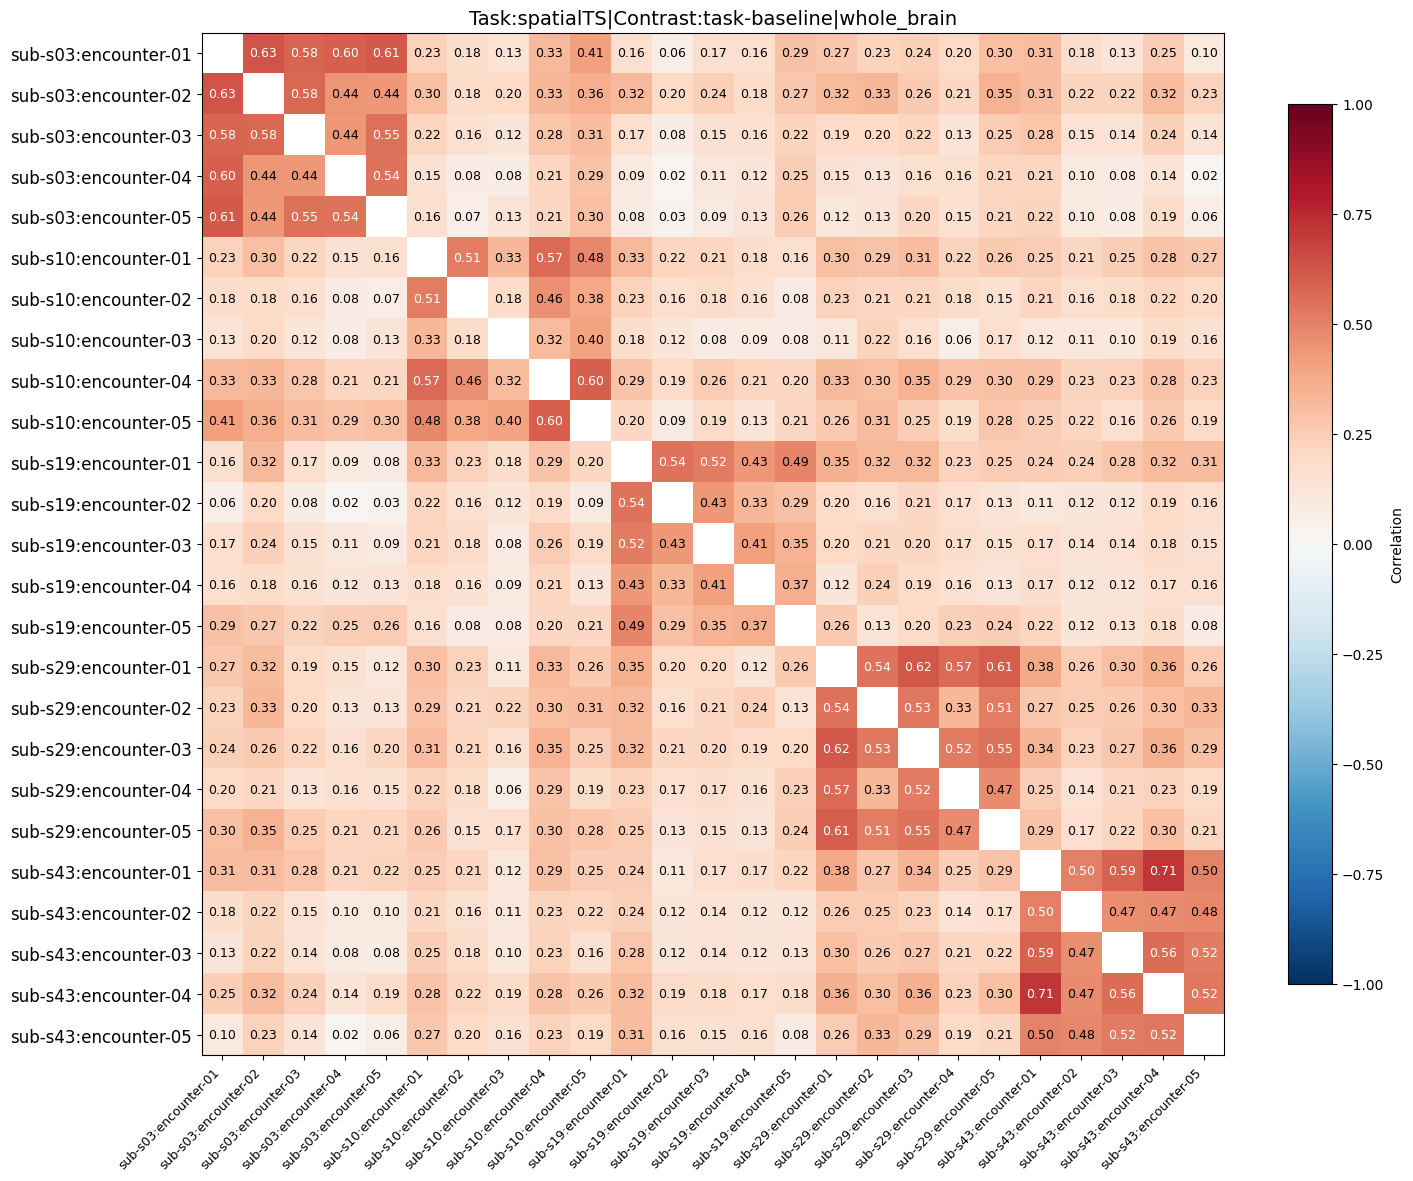

In [6]:
# plot whole brain
for task in requested_task_contrasts.keys():
    for contrast in requested_task_contrasts[task]:
        plot_rsm_clean(all_rsms, task, contrast,'whole_brain')
        plot_rsm_clean(all_rsms, task, 'task-baseline','whole_brain')

## Visualizing similarity change across specific networks over time

In [7]:
REGIONS = ["whole_brain", "1_Visual", "2_Somatomotor", "3_Dorsal Attention", "4_Ventral Attention", "5_Limbic",
              "6_Frontoparietal Control", "7_Default Mode"]

In [8]:
regions_of_interest = ["whole_brain", "6_Frontoparietal Control", "7_Default Mode", "3_Dorsal Attention"]

In [9]:
# for each region, go to the task/contrast and save the correlations for enc 0, enc 1, enc 2, etc to a list each
encounter_specific_corrs = {}
for region in REGIONS:
    encounter_specific_corrs[region] = {}

    for task in TASKS:
        encounter_specific_corrs[region][task] = {}

        for contrast in CONTRASTS[task]:
            encounter_specific_corrs[region][task][contrast] = {"1":[], "2":[], "3":[], "4":[], "5":[]}

            try:
                rsm_data = all_rsms[task][contrast][region]
                # Use rsm_data
            
            except KeyError as e:
                # Handle missing key
                print(f"Key not found: {e} so continuing")
                continue
        
            rsm_data = all_rsms[task][contrast][region]
            rsm_matrix = rsm_data['rsm']
            descriptors = rsm_data['descriptors']

            # label the data with which encounter each map belongs to
            encounter_map_indices = {}  # encounter_id -> [map indices]
            
            for i, desc in enumerate(descriptors):
                # format: descriptor_name = f"{subject}:encounter-0{encounter + 1}"
                encounter_id = desc.split('encounter-0')[1]
                
                if encounter_id not in encounter_map_indices:
                    encounter_map_indices[encounter_id] = []
                
                encounter_map_indices[encounter_id].append(i)
        
            upper_tri = np.triu_indices_from(rsm_matrix, k=1)
            all_correlations = rsm_matrix[upper_tri]
                        
            for idx, (row, col) in enumerate(zip(upper_tri[0], upper_tri[1])):
                # Find which encounters these two maps belong to
                enc_for_map_row = None
                enc_for_map_col = None
                
                for encounter_id, map_indices in encounter_map_indices.items():
                    if row in map_indices:
                        enc_for_map_row = encounter_id
                    if col in map_indices:
                        enc_for_map_col = encounter_id
                        
                # get the corr
                correlation_value = all_correlations[idx]
        
                # put the corr into assigned group
                # only include if its the same encounter both ways 
                if enc_for_map_row == enc_for_map_col:
                    # Same encounter
                    encounter_specific_corrs[region][task][contrast][enc_for_map_row].append(correlation_value)                    
                    

In [10]:
# Calculate mean between-subject correlation for each encounter (same as before)
encounter_means = {}
for region in REGIONS:
    encounter_means[region] = {}
    for task in TASKS:
        encounter_means[region][task] = {}
        for contrast in CONTRASTS[task]:
            encounter_means[region][task][contrast] = {}
            for encounter in ["1", "2", "3", "4", "5"]:
                corrs = encounter_specific_corrs[region][task][contrast][encounter]
                if corrs:
                    encounter_means[region][task][contrast][encounter] = np.mean(corrs)
                else:
                    encounter_means[region][task][contrast][encounter] = np.nan

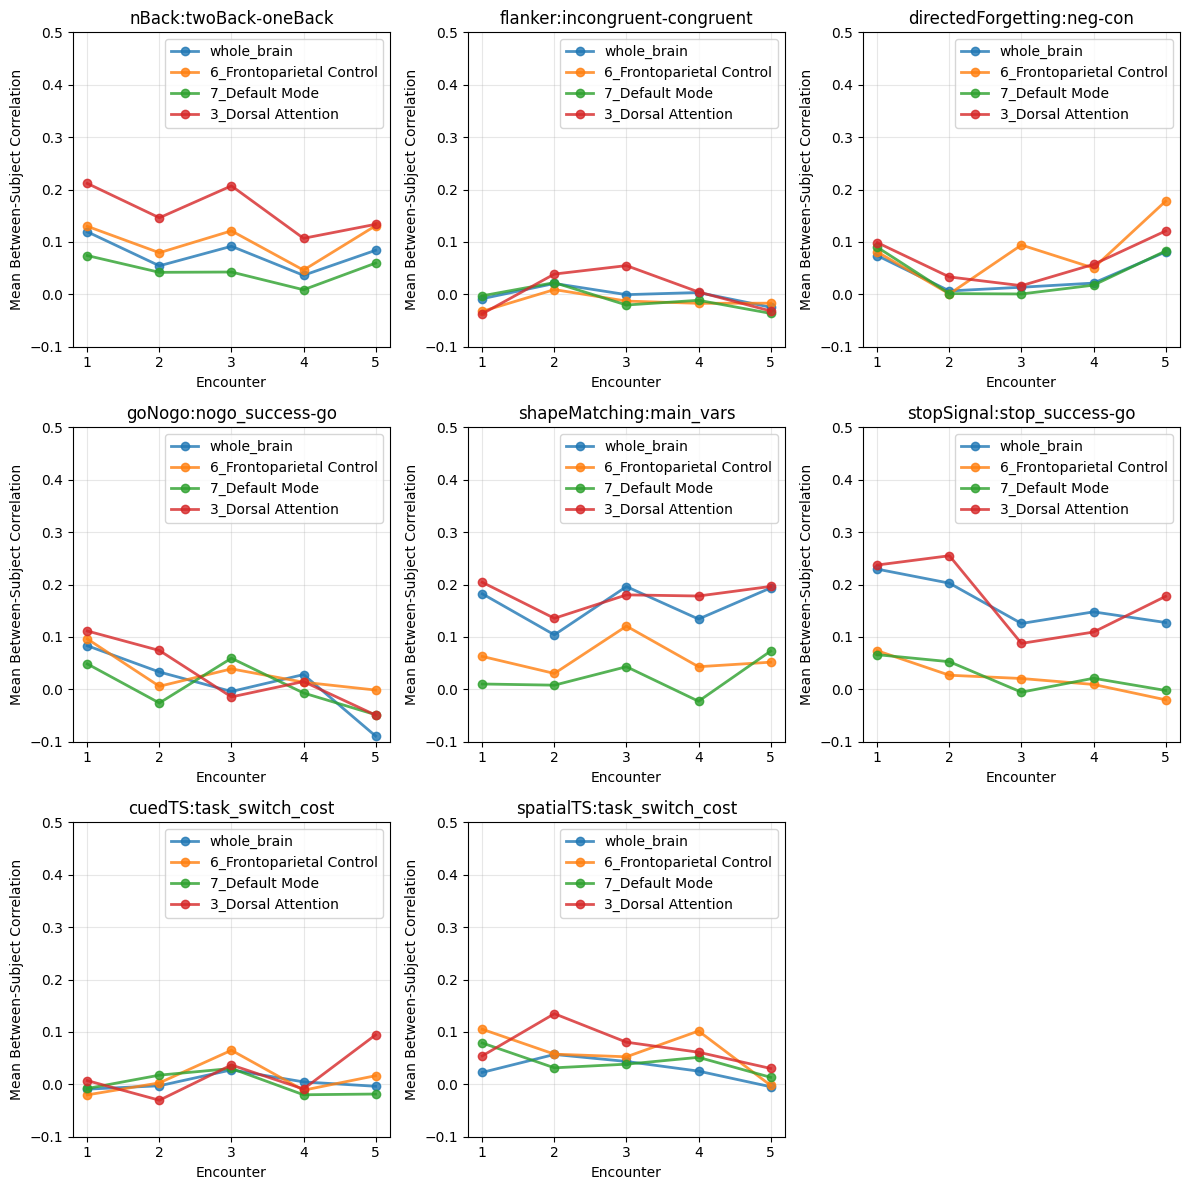

In [11]:
# plot change over time, only for regions of interest and requested_task_contrasts
tasks_contrasts = [(task, contrast) for task in requested_task_contrasts.keys() 
                   for contrast in requested_task_contrasts[task]]

num_plots = len(tasks_contrasts)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# single row case
if num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (task, contrast) in enumerate(tasks_contrasts):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    
    encounters = ["1", "2", "3", "4", "5"]
    
    # Plot each region as a separate line
    for region in regions_of_interest:
        means = [encounter_means[region][task][contrast][enc] for enc in encounters]
        ax.plot(encounters, means, 'o-', linewidth=2, markersize=6, 
               label=region, alpha=0.8)
    
    ax.set_xlabel('Encounter')
    ax.set_ylabel('Mean Between-Subject Correlation')
    ax.set_title(f'{task}:{contrast}')
    ax.set_ylim(-0.1, 0.5)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(num_plots, num_rows * num_cols):
    row = idx // num_cols
    col = idx % num_cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

# visualizing consecutive encounter similarity within subject

In [12]:
# For each subject, track correlations between different encounters
within_subj_cross_encounter_vals = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

for subj in SUBJECTS:
    for region in REGIONS:
        for task in TASKS:
            for contrast in CONTRASTS[task]:

                try:
                    rsm_data = all_rsms[task][contrast][region]
                    # Use rsm_data
                
                except KeyError as e:
                    # Handle missing key
                    print(f"Key not found: {e} so continuing")
                    continue

                rsm_matrix = rsm_data['rsm']
                descriptors = rsm_data['descriptors']
                
                # Map indices to encounters for this subject only
                encounter_map_indices = defaultdict(list)
                
                for i, desc in enumerate(descriptors):
                    subject_id = desc.split(':')[0]
                    if subject_id == subj:  # Only process maps for current subject
                        encounter_id = desc.split('encounter-0')[1]
                        encounter_map_indices[encounter_id].append(i)
                
                # Get correlations between different encounters
                upper_tri = np.triu_indices_from(rsm_matrix, k=0)
                
                for idx, (row, col) in enumerate(zip(upper_tri[0], upper_tri[1])):
                    # Find encounters for these maps
                    enc_row = None
                    enc_col = None
                    
                    for encounter_id, map_indices in encounter_map_indices.items():
                        if row in map_indices:
                            enc_row = encounter_id
                        if col in map_indices:
                            enc_col = encounter_id
                    
                    # Only include if both maps are from current subject
                    if enc_row and enc_col:
                        if enc_row == enc_col:
                            correlation_value = 1.0
                        else:
                            correlation_value = rsm_matrix[row, col]
                        
                        # Store bidirectionally (1->2 and 2->1)
                        within_subj_cross_encounter_vals[subj][task][contrast][region][f"{enc_row}_{enc_col}"].append(correlation_value)                                        
                        # Record the reverse pair 
                        within_subj_cross_encounter_vals[subj][task][contrast][region][f"{enc_col}_{enc_row}"].append(correlation_value)


In [13]:
# Plot a heatmap showing average within-subject similarity between encounter pairs
def plot_encounter_similarity_heatmap(data, task, contrast, region):
    """Create heatmap of average similarity between encounter pairs"""
    
    # Collect all encounter pairs and their correlations
    encounter_pairs = defaultdict(list)
    
    for subj in data.keys():
        for pair_key, correlations in data[subj][task][contrast][region].items():
            encounter_pairs[pair_key].extend(correlations)
    
    # Create matrix for heatmap
    encounters = sorted(set([p.split('_')[0] for p in encounter_pairs.keys()] + 
                           [p.split('_')[1] for p in encounter_pairs.keys()]))
    
    similarity_matrix = np.zeros((len(encounters), len(encounters)))
    
    for i, enc1 in enumerate(encounters):
        for j, enc2 in enumerate(encounters):

            pair_key = f"{enc1}_{enc2}"
            if pair_key in encounter_pairs:
                similarity_matrix[i, j] = np.mean(encounter_pairs[pair_key])
            else:
                pair_key = f"{enc2}_{enc1}"
                if pair_key in encounter_pairs:
                    similarity_matrix[i, j] = np.mean(encounter_pairs[pair_key])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, 
                xticklabels=encounters, 
                yticklabels=encounters,
                annot=True, 
                cmap='RdYlBu_r',
                center=0,
                square=True)
    plt.title(f'Cross-Encounter Similarity: {task} - {contrast} - {region}')
    plt.xlabel('Encounter')
    plt.ylabel('Encounter')
    plt.tight_layout()
    plt.show()

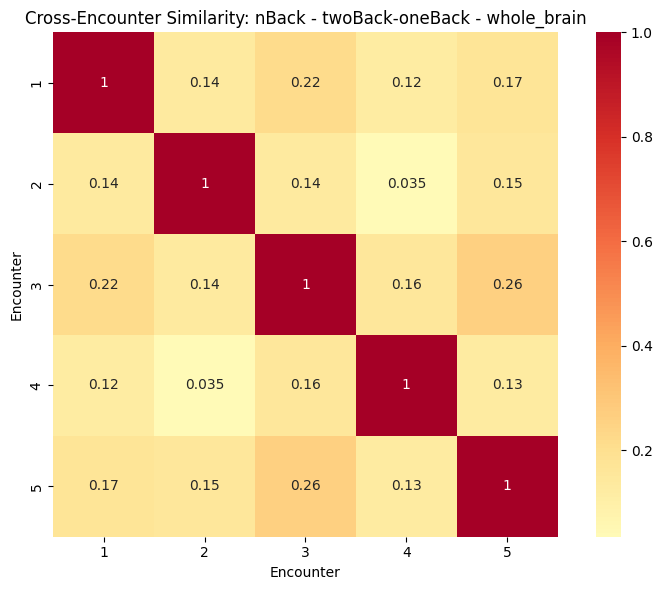

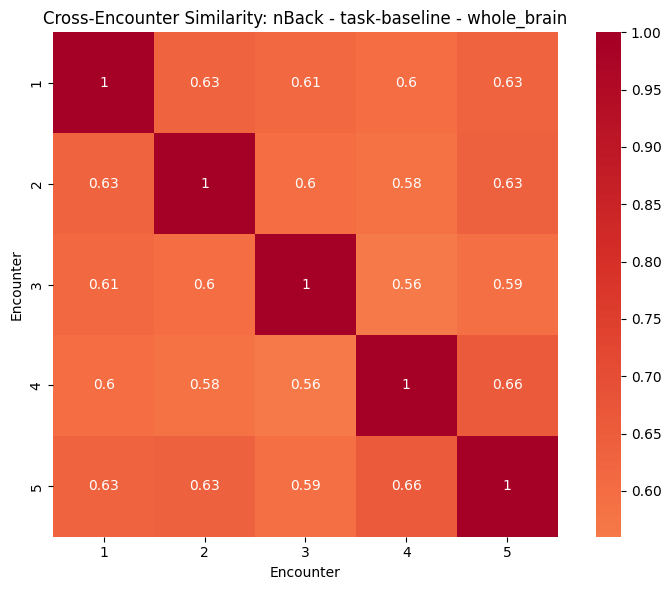

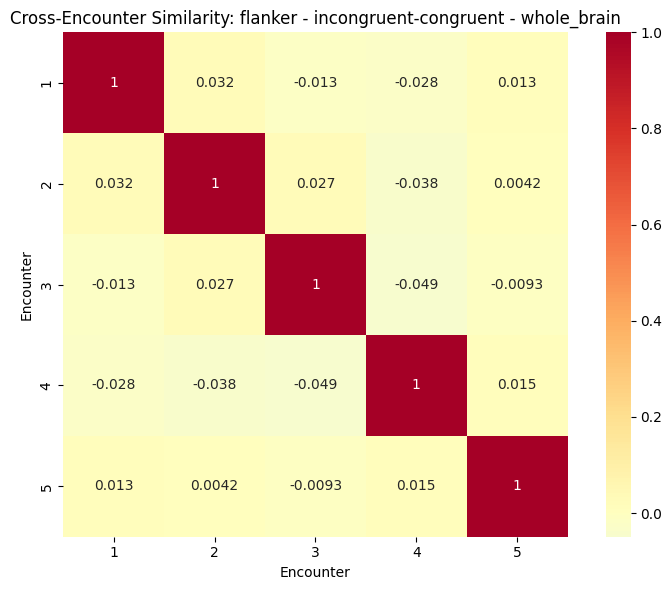

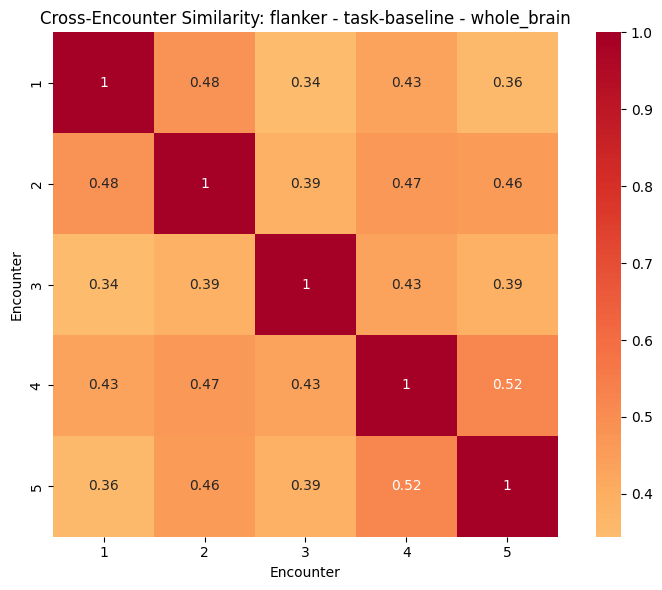

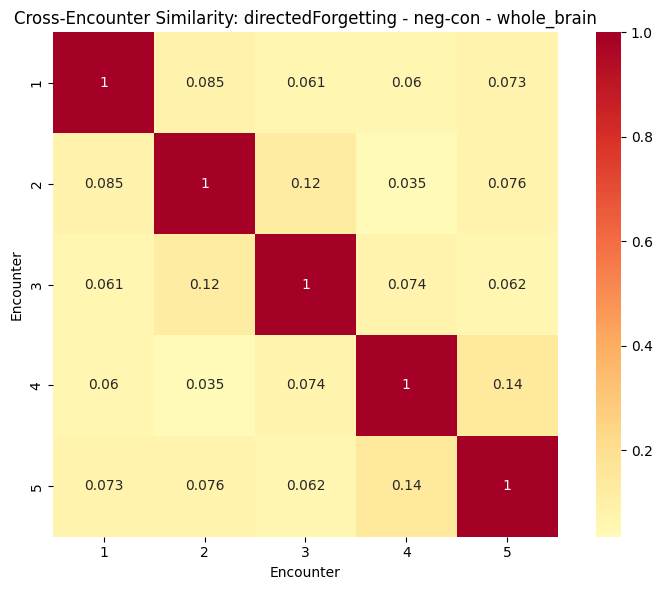

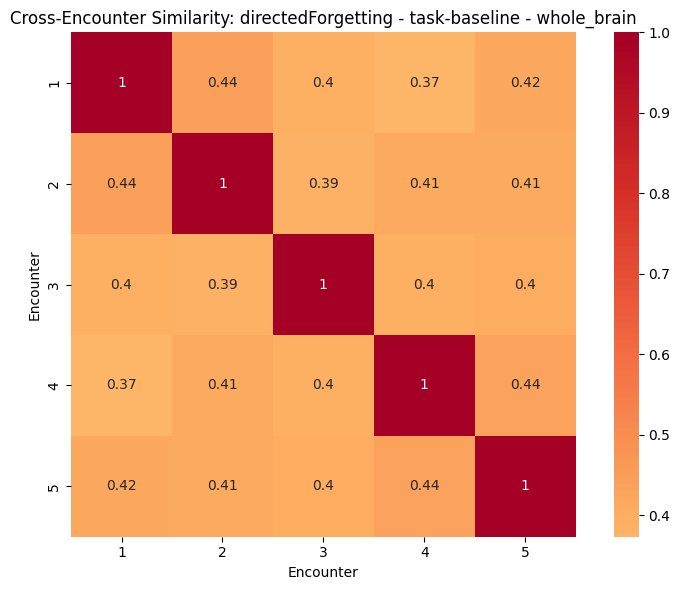

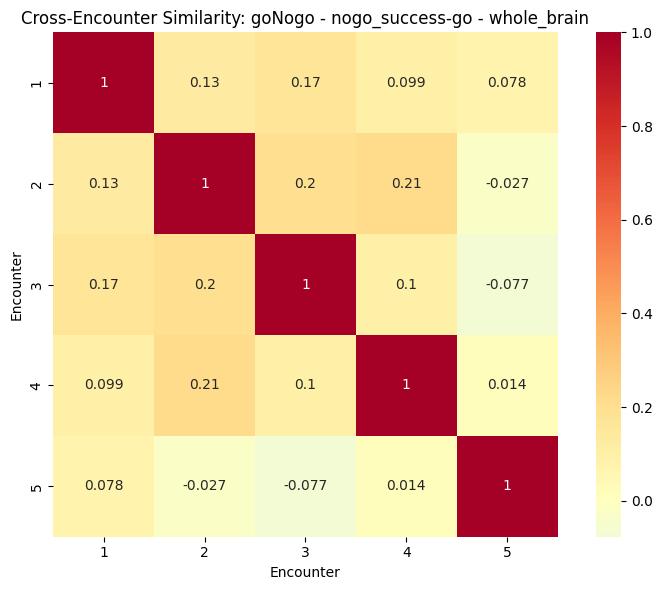

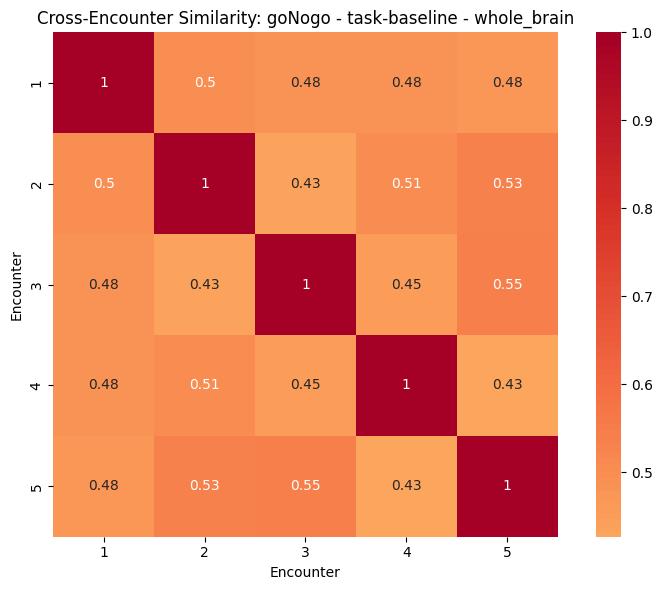

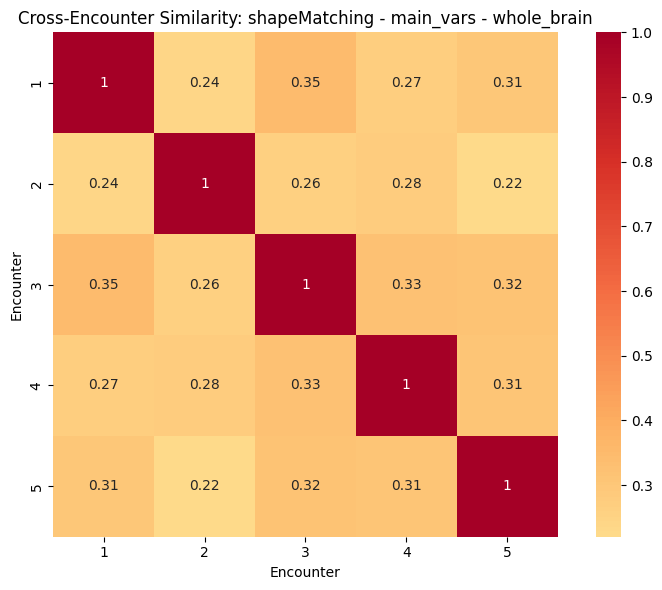

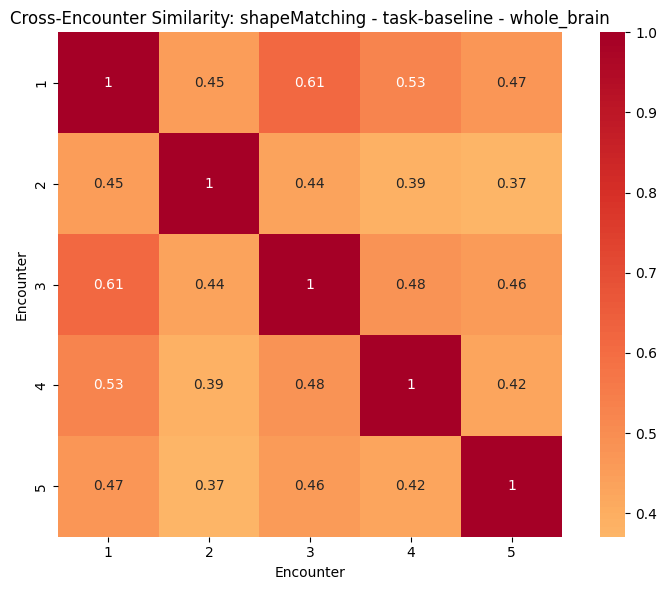

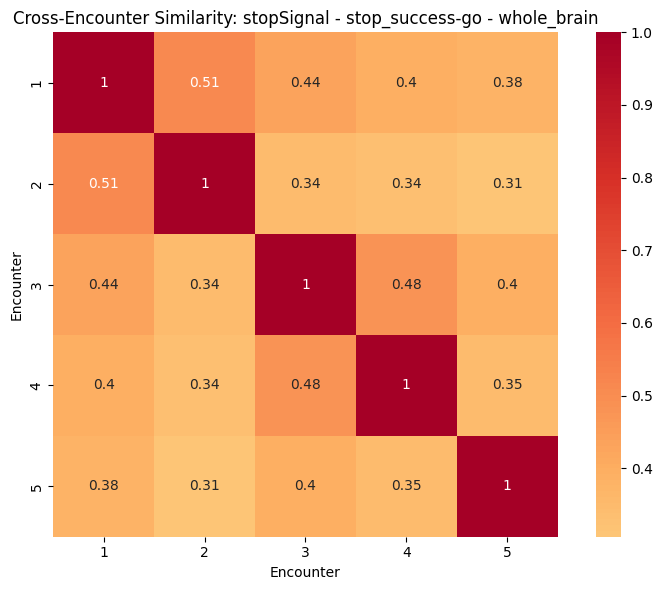

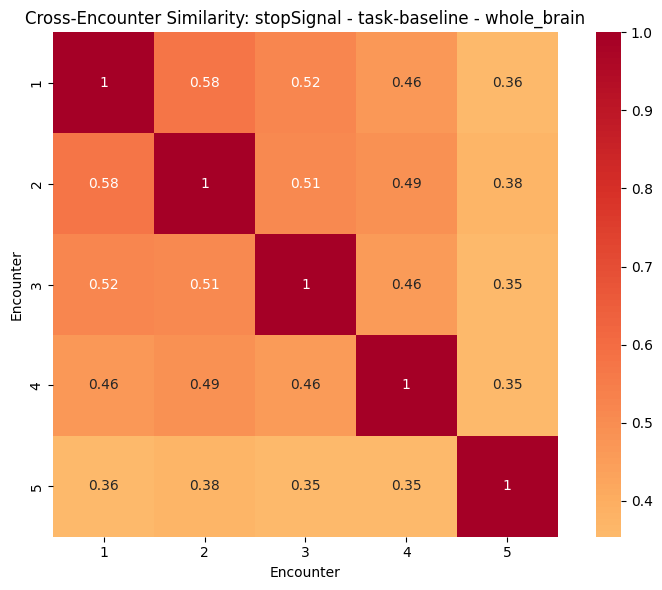

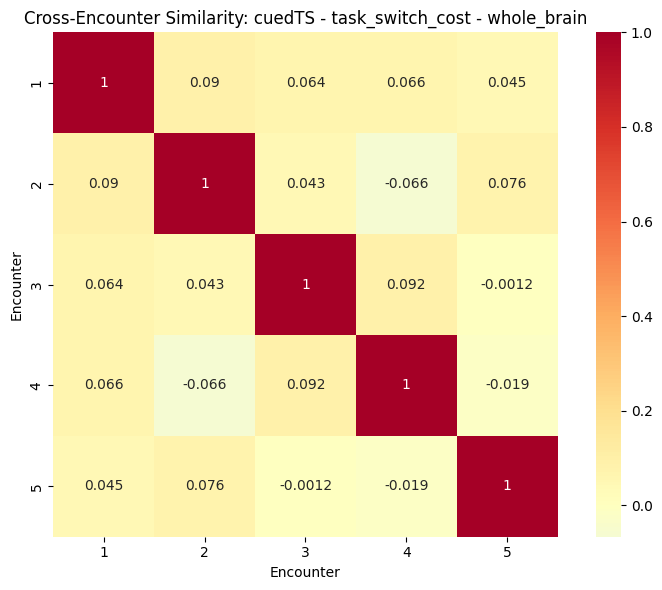

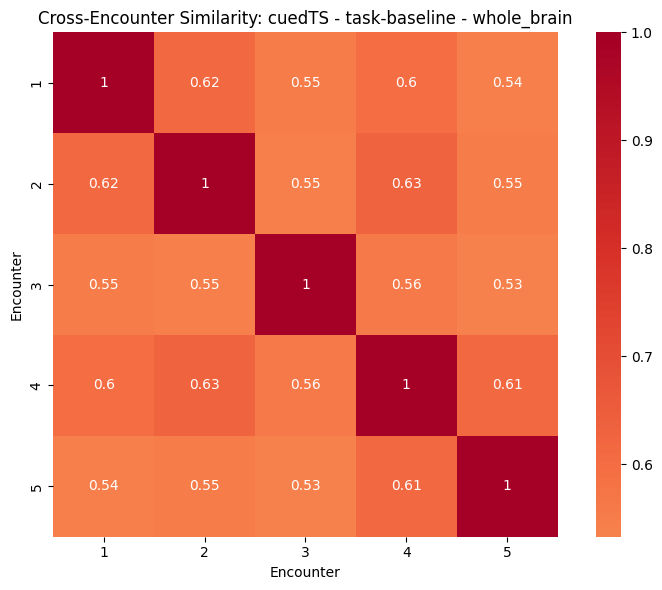

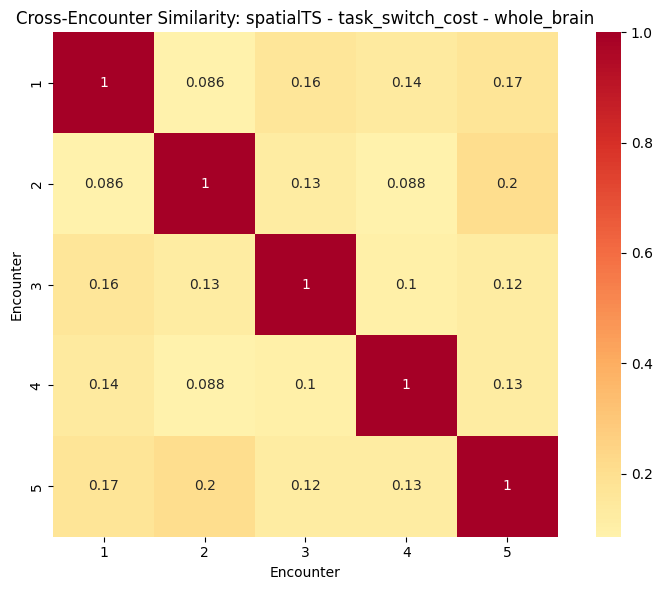

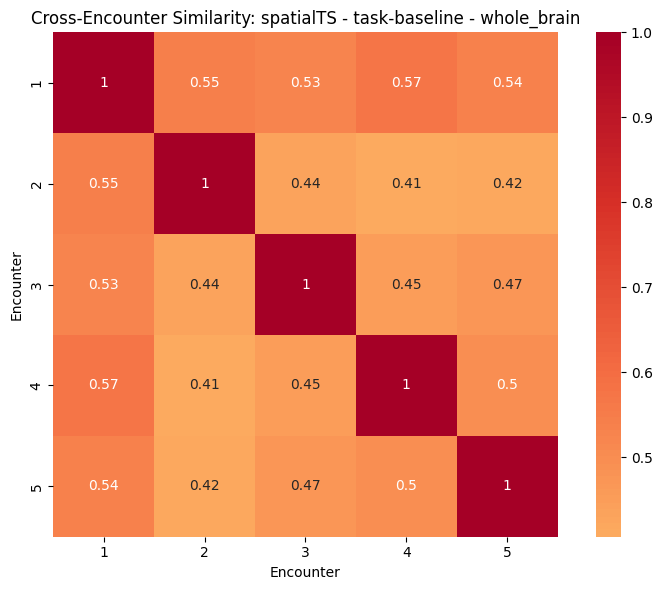

In [14]:
if generate_no_rt_results:
    requested_task_contrasts = {"flanker":["incongruent-congruent", "task-baseline"]}
    

for task in requested_task_contrasts.keys():
    for contrast in requested_task_contrasts[task]:
        plot_encounter_similarity_heatmap(within_subj_cross_encounter_vals, task, contrast, 'whole_brain')
        plot_encounter_similarity_heatmap(within_subj_cross_encounter_vals, task, 'task-baseline', 'whole_brain')

In [15]:
# TODO: make a plot where it has, per subject a plot, where each line is comparing one encounter to all other encounters (i.e. a line labeled "1" which is 1 vs 1, 1 vs 2, 1 vs 3, etc)